In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0
else:
    print("Not Google Colab")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

In [ ]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# クレジットカードの不正利用をEfficientGANsを用いて検知するアルゴリズムを実装する

## １.データの準備

In [ ]:
#データ読み込み用の関数を定義
#クレジットカードの不正利用検知
#元データ： https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
class Read_data:
    def __init__(self,file_pass,label_col_name):
        self.file_pass = file_pass
        self.label_col_name = label_col_name
        self.set_data()

    def set_data(self):
        self.df = pd.read_csv(self.file_pass)

    def get_label_data(self):
        return self.df[self.label_col_name].values

    def extract_feature_data(self):
        return self.df.drop(columns = self.label_col_name)

    def get_scalize_feature_data(self):
        scaler = MinMaxScaler()
        featrue_data = self.extract_feature_data()
        scalize_feature_data = scaler.fit_transform(featrue_data)

        return scalize_feature_data

    def drop_cols(self,list_drop_cols):
        self.df = self.df.drop(columns = list_drop_cols)


In [ ]:
# データセットの読み込み
from sklearn.preprocessing import MinMaxScaler
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # Pathの設定
    jesc_path = '/content/drive/MyDrive/creditcard.csv'
else:
    jesc_path = 'creditcard.csv'

data = Read_data(jesc_path,'Class')
data.drop_cols('Time')
feature = data.get_scalize_feature_data()
label = data.get_label_data()

In [ ]:
# データセットの整形
df = pd.read_csv(jesc_path)

feature = df.iloc[:,1:-1].values        #  V1～V28, Amount
label = df['Class'].values              # 正常/不正ラベル
# 特徴量を範囲0-1にスケールする
scaler = MinMaxScaler()
feature = scaler.fit_transform(feature)

In [ ]:
class Split_data_train_test:
    def __init__(self,feature,label):
        self.feature = feature
        self.label = label

    def get_splited_data(self,test_size = 0.333,shuffle = False):
        X_train, X_test, y_train, y_test = train_test_split(self.feature, self.label, test_size=0.333, shuffle=False)

        return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = Split_data_train_test(feature,label).get_splited_data()

In [ ]:
#データの分割
import numpy as np

X_train_regular = X_train[np.where(y_train==0)]
X_train_anomaly = X_train[np.where(y_train==1)]
X_test_regular = X_test[np.where(y_test==0)]
X_test_anomaly = X_test[np.where(y_test==1)]

In [ ]:
#データ数の確認
print(X_train_regular.shape)
print(X_train_anomaly.shape)
print(X_test_regular.shape)
print(X_test_anomaly.shape)

(189595, 29)
(371, 29)
(94720, 29)
(121, 29)


## 2.アーキテクチャの実装
### 参考：https://www.koi.mashykom.com/anomaly_detection.html

In [ ]:
#　　ジェネレータの実装
class Generator(nn.Module):

    def __init__(self, z_dim=10):
        super(Generator, self).__init__()
        #　　参考元では畳み込み層を用いていたが、今回は全結合層を使用
        #　　今回のデータは画像ではなく、リレーショナルデータのため
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(20, 29),
            nn.BatchNorm1d(29),
            nn.ReLU(inplace=True))



    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)


        return out


In [ ]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=10)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 10)

fake = G(input_z)  # torch.Size([2, 1, 28, 28])
fake_transformed = fake[0].detach().numpy()


In [ ]:
#ディスクリミネーターの実装
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, z_dim=10):
        super(Discriminator, self).__init__()

        #　参考元では畳み込み層を用いていたが、今回は全結合層を使用
        #　今回のデータは画像ではなく、リレーショナルデータのため
        #　データ側の入力処理
        #　学習の際に、ディスクリミネーターが強くなりすぎるため、レイヤーを一つに絞る
        self.x_layer1 = nn.Sequential(
            nn.Linear(29, 20),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Linear(20, 10),
            nn.LeakyReLU(0.1, inplace=True))

        #　乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 10)

        self.last1 = nn.Sequential(
            nn.Linear(20, 10),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(10, 1)


    def forward(self, x, z):
         #　データ側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        #　乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        #　x_outとz_outを結合し、全結合層で判定
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last2(out)

        return out, feature


In [ ]:
# 動作確認
D = Discriminator(z_dim=10)

# 偽データを生成
input_z = torch.randn(2, 10)
fake = G(input_z)

# 偽データをDに入力
d_out, _ = D(fake, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))
d_out.view(-1)

tensor([[0.5153],
        [0.5022]], grad_fn=<SigmoidBackward0>)


tensor([0.0614, 0.0087], grad_fn=<ViewBackward0>)

In [ ]:
#エンコーダーの実装

class Encoder(nn.Module):
    def __init__(self, z_dim=29):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(29, 20),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(0.1, inplace=True))


    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        out = self.layer2(out)

        return out


In [ ]:
# 動作確認
E = Encoder(z_dim=29)

# 入力する画像データ
x = fake  # fakeは上のGで作成したもの

# 画像からzをEncode
z = E(x)

print(z.shape)
print(z)


torch.Size([2, 10])
tensor([[-0.0999, -0.0997,  0.9986,  0.9996,  0.9993, -0.0999,  0.9996, -0.0998,
          0.9954,  0.9974],
        [ 0.9986,  0.9968, -0.0999, -0.1000, -0.0999,  0.9994, -0.1000,  0.9981,
         -0.0995, -0.0997]], grad_fn=<LeakyReluBackward1>)


## ３.学習

In [ ]:
from tqdm import tqdm
# モデルを学習させる関数を作成


def train_model(G, D, E, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    # ディスクリミネーターが強くなりすぎないように、ジェネレータ：ディスクリミネーター　= 4:1の割合で学習
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 10
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # データ数
    num_train_data = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for data in tqdm(dataloader):
            data = data[0]

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if data.size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = data.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            data = data.to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真のデータを判定
            z_out_real = E(data)
            d_out_real, _ = D(data, z_out_real)

            # 偽のデータを生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake = G(input_z)
            d_out_fake, _ = D(fake, input_z)

            # 誤差を計算
            #d_loss_real = criterion(d_out_real.view(-1), label_real)
            #d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            #d_loss = d_loss_real + d_loss_fake
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽のデータを生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake = G(input_z)
            d_out_fake, _ = D(fake, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真のデータのzを推定
            z_out_real = E(data)
            d_out_real, _ = D(data, z_out_real)

            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E


In [ ]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [ ]:
#1h程度かかる
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_regular = torch.Tensor(X_train_regular).to(device)
batch_size=2048
# 学習・検証を実行する
train_dataset = TensorDataset(X_train_regular, X_train_regular)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.67it/s]


-------------
epoch 0 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0334 ||Epoch_E_Loss:0.0313
timer:  3.2563 sec.
-------------
Epoch 1/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.15it/s]


-------------
epoch 1 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0335 ||Epoch_E_Loss:0.0314
timer:  3.4355 sec.
-------------
Epoch 2/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.44it/s]


-------------
epoch 2 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0315
timer:  2.6327 sec.
-------------
Epoch 3/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.63it/s]


-------------
epoch 3 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0337 ||Epoch_E_Loss:0.0315
timer:  2.6955 sec.
-------------
Epoch 4/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.28it/s]


-------------
epoch 4 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0338 ||Epoch_E_Loss:0.0316
timer:  2.6431 sec.
-------------
Epoch 5/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.28it/s]


-------------
epoch 5 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0339 ||Epoch_E_Loss:0.0316
timer:  3.5534 sec.
-------------
Epoch 6/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.12it/s]


-------------
epoch 6 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0340 ||Epoch_E_Loss:0.0317
timer:  2.9064 sec.
-------------
Epoch 7/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 7 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0342 ||Epoch_E_Loss:0.0317
timer:  2.6709 sec.
-------------
Epoch 8/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.26it/s]


-------------
epoch 8 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0343 ||Epoch_E_Loss:0.0318
timer:  2.5758 sec.
-------------
Epoch 9/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.30it/s]


-------------
epoch 9 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0319
timer:  2.7208 sec.
-------------
Epoch 10/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.09it/s]


-------------
epoch 10 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0346 ||Epoch_E_Loss:0.0320
timer:  4.2232 sec.
-------------
Epoch 11/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.88it/s]


-------------
epoch 11 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0348 ||Epoch_E_Loss:0.0321
timer:  3.7481 sec.
-------------
Epoch 12/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.56it/s]


-------------
epoch 12 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0349 ||Epoch_E_Loss:0.0323
timer:  2.7019 sec.
-------------
Epoch 13/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.77it/s]


-------------
epoch 13 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0350 ||Epoch_E_Loss:0.0325
timer:  2.6090 sec.
-------------
Epoch 14/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.07it/s]


-------------
epoch 14 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0351 ||Epoch_E_Loss:0.0327
timer:  2.9098 sec.
-------------
Epoch 15/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.08it/s]


-------------
epoch 15 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0352 ||Epoch_E_Loss:0.0329
timer:  3.5740 sec.
-------------
Epoch 16/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.44it/s]


-------------
epoch 16 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0353 ||Epoch_E_Loss:0.0330
timer:  2.7092 sec.
-------------
Epoch 17/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.83it/s]


-------------
epoch 17 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0354 ||Epoch_E_Loss:0.0332
timer:  2.5326 sec.
-------------
Epoch 18/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.82it/s]


-------------
epoch 18 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0356 ||Epoch_E_Loss:0.0334
timer:  2.6821 sec.
-------------
Epoch 19/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.98it/s]


-------------
epoch 19 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0358 ||Epoch_E_Loss:0.0335
timer:  3.0160 sec.
-------------
Epoch 20/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.31it/s]


-------------
epoch 20 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.0359 ||Epoch_E_Loss:0.0337
timer:  3.5446 sec.
-------------
Epoch 21/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.56it/s]


-------------
epoch 21 || Epoch_D_Loss:0.0568 ||Epoch_G_Loss:0.0360 ||Epoch_E_Loss:0.0339
timer:  2.6265 sec.
-------------
Epoch 22/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.90it/s]


-------------
epoch 22 || Epoch_D_Loss:0.0566 ||Epoch_G_Loss:0.0361 ||Epoch_E_Loss:0.0340
timer:  2.7503 sec.
-------------
Epoch 23/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.04it/s]


-------------
epoch 23 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.0362 ||Epoch_E_Loss:0.0342
timer:  2.7397 sec.
-------------
Epoch 24/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.97it/s]


-------------
epoch 24 || Epoch_D_Loss:0.0562 ||Epoch_G_Loss:0.0363 ||Epoch_E_Loss:0.0344
timer:  3.4615 sec.
-------------
Epoch 25/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.33it/s]


-------------
epoch 25 || Epoch_D_Loss:0.0560 ||Epoch_G_Loss:0.0363 ||Epoch_E_Loss:0.0346
timer:  3.1795 sec.
-------------
Epoch 26/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.33it/s]


-------------
epoch 26 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:0.0363 ||Epoch_E_Loss:0.0348
timer:  2.6392 sec.
-------------
Epoch 27/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.27it/s]


-------------
epoch 27 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0364 ||Epoch_E_Loss:0.0349
timer:  2.7222 sec.
-------------
Epoch 28/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.55it/s]


-------------
epoch 28 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0364 ||Epoch_E_Loss:0.0351
timer:  2.5537 sec.
-------------
Epoch 29/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.01it/s]


-------------
epoch 29 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0365 ||Epoch_E_Loss:0.0352
timer:  3.7312 sec.
-------------
Epoch 30/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.43it/s]


-------------
epoch 30 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0354
timer:  2.7074 sec.
-------------
Epoch 31/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.83it/s]


-------------
epoch 31 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0356
timer:  2.7587 sec.
-------------
Epoch 32/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.71it/s]


-------------
epoch 32 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0358
timer:  2.5451 sec.
-------------
Epoch 33/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.48it/s]


-------------
epoch 33 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0359
timer:  2.7906 sec.
-------------
Epoch 34/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.63it/s]


-------------
epoch 34 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0361
timer:  3.6400 sec.
-------------
Epoch 35/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.65it/s]


-------------
epoch 35 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0363
timer:  2.5448 sec.
-------------
Epoch 36/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.70it/s]


-------------
epoch 36 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0367 ||Epoch_E_Loss:0.0364
timer:  2.6154 sec.
-------------
Epoch 37/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.55it/s]


-------------
epoch 37 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0367
timer:  2.4865 sec.
-------------
Epoch 38/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.48it/s]


-------------
epoch 38 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0368
timer:  2.8792 sec.
-------------
Epoch 39/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.88it/s]


-------------
epoch 39 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0369
timer:  3.4669 sec.
-------------
Epoch 40/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.65it/s]


-------------
epoch 40 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0367 ||Epoch_E_Loss:0.0370
timer:  2.6938 sec.
-------------
Epoch 41/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.01it/s]


-------------
epoch 41 || Epoch_D_Loss:0.0538 ||Epoch_G_Loss:0.0368 ||Epoch_E_Loss:0.0370
timer:  2.5211 sec.
-------------
Epoch 42/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.37it/s]


-------------
epoch 42 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0369 ||Epoch_E_Loss:0.0370
timer:  2.6373 sec.
-------------
Epoch 43/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.17it/s]


-------------
epoch 43 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0371 ||Epoch_E_Loss:0.0370
timer:  2.9054 sec.
-------------
Epoch 44/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.73it/s]


-------------
epoch 44 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0373 ||Epoch_E_Loss:0.0370
timer:  3.4895 sec.
-------------
Epoch 45/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.64it/s]


-------------
epoch 45 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0374 ||Epoch_E_Loss:0.0370
timer:  2.6165 sec.
-------------
Epoch 46/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.04it/s]


-------------
epoch 46 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0374 ||Epoch_E_Loss:0.0372
timer:  2.5193 sec.
-------------
Epoch 47/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.79it/s]


-------------
epoch 47 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0373 ||Epoch_E_Loss:0.0375
timer:  2.6081 sec.
-------------
Epoch 48/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.49it/s]


-------------
epoch 48 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0372 ||Epoch_E_Loss:0.0376
timer:  2.9697 sec.
-------------
Epoch 49/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.43it/s]


-------------
epoch 49 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0372 ||Epoch_E_Loss:0.0376
timer:  3.4025 sec.
-------------
Epoch 50/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.27it/s]


-------------
epoch 50 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0373 ||Epoch_E_Loss:0.0376
timer:  2.5025 sec.
-------------
Epoch 51/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.78it/s]


-------------
epoch 51 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0375 ||Epoch_E_Loss:0.0375
timer:  2.6098 sec.
-------------
Epoch 52/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.89it/s]


-------------
epoch 52 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0378 ||Epoch_E_Loss:0.0373
timer:  2.5287 sec.
-------------
Epoch 53/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.11it/s]


-------------
epoch 53 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0380 ||Epoch_E_Loss:0.0373
timer:  3.3182 sec.
-------------
Epoch 54/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.52it/s]


-------------
epoch 54 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0380 ||Epoch_E_Loss:0.0373
timer:  3.1592 sec.
-------------
Epoch 55/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.30it/s]


-------------
epoch 55 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0383 ||Epoch_E_Loss:0.0372
timer:  2.7186 sec.
-------------
Epoch 56/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.30it/s]


-------------
epoch 56 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0384 ||Epoch_E_Loss:0.0372
timer:  2.7273 sec.
-------------
Epoch 57/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.91it/s]


-------------
epoch 57 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0385 ||Epoch_E_Loss:0.0372
timer:  2.5975 sec.
-------------
Epoch 58/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.19it/s]


-------------
epoch 58 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0385 ||Epoch_E_Loss:0.0372
timer:  3.7002 sec.
-------------
Epoch 59/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.12it/s]


-------------
epoch 59 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0387 ||Epoch_E_Loss:0.0371
timer:  2.8181 sec.
-------------
Epoch 60/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.58it/s]


-------------
epoch 60 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0389 ||Epoch_E_Loss:0.0371
timer:  2.6997 sec.
-------------
Epoch 61/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.21it/s]


-------------
epoch 61 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0392 ||Epoch_E_Loss:0.0370
timer:  2.5759 sec.
-------------
Epoch 62/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.35it/s]


-------------
epoch 62 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0394 ||Epoch_E_Loss:0.0369
timer:  2.9753 sec.
-------------
Epoch 63/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.27it/s]


-------------
epoch 63 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0396 ||Epoch_E_Loss:0.0369
timer:  3.6894 sec.
-------------
Epoch 64/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.26it/s]


-------------
epoch 64 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0399 ||Epoch_E_Loss:0.0369
timer:  2.8043 sec.
-------------
Epoch 65/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.38it/s]


-------------
epoch 65 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0401 ||Epoch_E_Loss:0.0368
timer:  2.6390 sec.
-------------
Epoch 66/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.70it/s]


-------------
epoch 66 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0405 ||Epoch_E_Loss:0.0367
timer:  2.7669 sec.
-------------
Epoch 67/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.07it/s]


-------------
epoch 67 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0408 ||Epoch_E_Loss:0.0365
timer:  3.3238 sec.
-------------
Epoch 68/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.46it/s]


-------------
epoch 68 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0364
timer:  3.1662 sec.
-------------
Epoch 69/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.68it/s]


-------------
epoch 69 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0363
timer:  2.6908 sec.
-------------
Epoch 70/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.25it/s]


-------------
epoch 70 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0419 ||Epoch_E_Loss:0.0362
timer:  2.6477 sec.
-------------
Epoch 71/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.29it/s]


-------------
epoch 71 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0421 ||Epoch_E_Loss:0.0361
timer:  2.7184 sec.
-------------
Epoch 72/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.32it/s]


-------------
epoch 72 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0360
timer:  3.5425 sec.
-------------
Epoch 73/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.15it/s]


-------------
epoch 73 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0426 ||Epoch_E_Loss:0.0360
timer:  3.0914 sec.
-------------
Epoch 74/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.59it/s]


-------------
epoch 74 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0429 ||Epoch_E_Loss:0.0360
timer:  2.6221 sec.
-------------
Epoch 75/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.27it/s]


-------------
epoch 75 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0431 ||Epoch_E_Loss:0.0359
timer:  2.7227 sec.
-------------
Epoch 76/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.55it/s]


-------------
epoch 76 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0433 ||Epoch_E_Loss:0.0358
timer:  2.7057 sec.
-------------
Epoch 77/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.29it/s]


-------------
epoch 77 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0435 ||Epoch_E_Loss:0.0358
timer:  3.8369 sec.
-------------
Epoch 78/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.26it/s]


-------------
epoch 78 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0435 ||Epoch_E_Loss:0.0358
timer:  2.7233 sec.
-------------
Epoch 79/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.30it/s]


-------------
epoch 79 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0357
timer:  2.5680 sec.
-------------
Epoch 80/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.69it/s]


-------------
epoch 80 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0357
timer:  2.7701 sec.
-------------
Epoch 81/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.31it/s]


-------------
epoch 81 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0356
timer:  2.9800 sec.
-------------
Epoch 82/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.18it/s]


-------------
epoch 82 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0447 ||Epoch_E_Loss:0.0355
timer:  3.5589 sec.
-------------
Epoch 83/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.16it/s]


-------------
epoch 83 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0355
timer:  2.5800 sec.
-------------
Epoch 84/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.12it/s]


-------------
epoch 84 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0452 ||Epoch_E_Loss:0.0354
timer:  2.7345 sec.
-------------
Epoch 85/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.75it/s]


-------------
epoch 85 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0456 ||Epoch_E_Loss:0.0354
timer:  2.6116 sec.
-------------
Epoch 86/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.63it/s]


-------------
epoch 86 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0353
timer:  3.4990 sec.
-------------
Epoch 87/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.28it/s]


-------------
epoch 87 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0353
timer:  3.6923 sec.
-------------
Epoch 88/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.20it/s]


-------------
epoch 88 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0462 ||Epoch_E_Loss:0.0352
timer:  3.3066 sec.
-------------
Epoch 89/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 89 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0463 ||Epoch_E_Loss:0.0351
timer:  2.7111 sec.
-------------
Epoch 90/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.23it/s]


-------------
epoch 90 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0468 ||Epoch_E_Loss:0.0351
timer:  2.9881 sec.
-------------
Epoch 91/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.84it/s]


-------------
epoch 91 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0468 ||Epoch_E_Loss:0.0351
timer:  3.4720 sec.
-------------
Epoch 92/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.98it/s]


-------------
epoch 92 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0471 ||Epoch_E_Loss:0.0351
timer:  2.5918 sec.
-------------
Epoch 93/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.38it/s]


-------------
epoch 93 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0472 ||Epoch_E_Loss:0.0350
timer:  2.7132 sec.
-------------
Epoch 94/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.86it/s]


-------------
epoch 94 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0350
timer:  2.6022 sec.
-------------
Epoch 95/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.78it/s]


-------------
epoch 95 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0351
timer:  3.3654 sec.
-------------
Epoch 96/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.08it/s]


-------------
epoch 96 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0475 ||Epoch_E_Loss:0.0351
timer:  3.0988 sec.
-------------
Epoch 97/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.36it/s]


-------------
epoch 97 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0475 ||Epoch_E_Loss:0.0351
timer:  2.7137 sec.
-------------
Epoch 98/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.85it/s]


-------------
epoch 98 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0475 ||Epoch_E_Loss:0.0352
timer:  2.6028 sec.
-------------
Epoch 99/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 99 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0476 ||Epoch_E_Loss:0.0352
timer:  2.6833 sec.
-------------
Epoch 100/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.95it/s]


-------------
epoch 100 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0351
timer:  3.7363 sec.
-------------
Epoch 101/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.13it/s]


-------------
epoch 101 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0351
timer:  2.6570 sec.
-------------
Epoch 102/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.20it/s]


-------------
epoch 102 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0480 ||Epoch_E_Loss:0.0350
timer:  2.6501 sec.
-------------
Epoch 103/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.83it/s]


-------------
epoch 103 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0487 ||Epoch_E_Loss:0.0349
timer:  2.6039 sec.
-------------
Epoch 104/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.23it/s]


-------------
epoch 104 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0347
timer:  2.8094 sec.
-------------
Epoch 105/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.90it/s]


-------------
epoch 105 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0346
timer:  3.6014 sec.
-------------
Epoch 106/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.86it/s]


-------------
epoch 106 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0345
timer:  2.6754 sec.
-------------
Epoch 107/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.40it/s]


-------------
epoch 107 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0495 ||Epoch_E_Loss:0.0344
timer:  2.5634 sec.
-------------
Epoch 108/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 108 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0344
timer:  2.7103 sec.
-------------
Epoch 109/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.67it/s]


-------------
epoch 109 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0498 ||Epoch_E_Loss:0.0344
timer:  2.8567 sec.
-------------
Epoch 110/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.75it/s]


-------------
epoch 110 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0345
timer:  3.6214 sec.
-------------
Epoch 111/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.87it/s]


-------------
epoch 111 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0500 ||Epoch_E_Loss:0.0345
timer:  2.6744 sec.
-------------
Epoch 112/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.31it/s]


-------------
epoch 112 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0501 ||Epoch_E_Loss:0.0345
timer:  2.5726 sec.
-------------
Epoch 113/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.48it/s]


-------------
epoch 113 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0345
timer:  2.7075 sec.
-------------
Epoch 114/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.77it/s]


-------------
epoch 114 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0507 ||Epoch_E_Loss:0.0346
timer:  3.0344 sec.
-------------
Epoch 115/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.30it/s]


-------------
epoch 115 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0348
timer:  3.4146 sec.
-------------
Epoch 116/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.36it/s]


-------------
epoch 116 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0506 ||Epoch_E_Loss:0.0349
timer:  2.5658 sec.
-------------
Epoch 117/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.06it/s]


-------------
epoch 117 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0510 ||Epoch_E_Loss:0.0349
timer:  2.7392 sec.
-------------
Epoch 118/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.44it/s]


-------------
epoch 118 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0509 ||Epoch_E_Loss:0.0350
timer:  2.5607 sec.
-------------
Epoch 119/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.94it/s]


-------------
epoch 119 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0508 ||Epoch_E_Loss:0.0351
timer:  3.4620 sec.
-------------
Epoch 120/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.98it/s]


-------------
epoch 120 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0509 ||Epoch_E_Loss:0.0352
timer:  3.0141 sec.
-------------
Epoch 121/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 121 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0510 ||Epoch_E_Loss:0.0353
timer:  2.6854 sec.
-------------
Epoch 122/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.81it/s]


-------------
epoch 122 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0354
timer:  2.6836 sec.
-------------
Epoch 123/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.82it/s]


-------------
epoch 123 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0355
timer:  2.6067 sec.
-------------
Epoch 124/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.40it/s]


-------------
epoch 124 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0514 ||Epoch_E_Loss:0.0355
timer:  3.8211 sec.
-------------
Epoch 125/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.02it/s]


-------------
epoch 125 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0515 ||Epoch_E_Loss:0.0356
timer:  2.5910 sec.
-------------
Epoch 126/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.36it/s]


-------------
epoch 126 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0356
timer:  2.7177 sec.
-------------
Epoch 127/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.05it/s]


-------------
epoch 127 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0357
timer:  2.5874 sec.
-------------
Epoch 128/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.93it/s]


-------------
epoch 128 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0357
timer:  3.1185 sec.
-------------
Epoch 129/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.08it/s]


-------------
epoch 129 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0524 ||Epoch_E_Loss:0.0358
timer:  3.3189 sec.
-------------
Epoch 130/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 130 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0527 ||Epoch_E_Loss:0.0359
timer:  2.6859 sec.
-------------
Epoch 131/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.79it/s]


-------------
epoch 131 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0360
timer:  2.6100 sec.
-------------
Epoch 132/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.09it/s]


-------------
epoch 132 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0361
timer:  2.7352 sec.
-------------
Epoch 133/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.78it/s]


-------------
epoch 133 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0363
timer:  3.3572 sec.
-------------
Epoch 134/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.01it/s]


-------------
epoch 134 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0364
timer:  3.0060 sec.
-------------
Epoch 135/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.49it/s]


-------------
epoch 135 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0537 ||Epoch_E_Loss:0.0365
timer:  2.7084 sec.
-------------
Epoch 136/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.50it/s]


-------------
epoch 136 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0539 ||Epoch_E_Loss:0.0366
timer:  2.6296 sec.
-------------
Epoch 137/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.07it/s]


-------------
epoch 137 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.0539 ||Epoch_E_Loss:0.0368
timer:  2.6601 sec.
-------------
Epoch 138/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.75it/s]


-------------
epoch 138 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0543 ||Epoch_E_Loss:0.0369
timer:  3.6199 sec.
-------------
Epoch 139/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.00it/s]


-------------
epoch 139 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0371
timer:  2.8244 sec.
-------------
Epoch 140/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.80it/s]


-------------
epoch 140 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0373
timer:  2.6064 sec.
-------------
Epoch 141/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 141 || Epoch_D_Loss:0.0483 ||Epoch_G_Loss:0.0545 ||Epoch_E_Loss:0.0375
timer:  2.6873 sec.
-------------
Epoch 142/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.74it/s]


-------------
epoch 142 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0377
timer:  2.8522 sec.
-------------
Epoch 143/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.23it/s]


-------------
epoch 143 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0378
timer:  3.5562 sec.
-------------
Epoch 144/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 144 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0379
timer:  2.7231 sec.
-------------
Epoch 145/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.49it/s]


-------------
epoch 145 || Epoch_D_Loss:0.0474 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0380
timer:  2.6321 sec.
-------------
Epoch 146/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.98it/s]


-------------
epoch 146 || Epoch_D_Loss:0.0472 ||Epoch_G_Loss:0.0553 ||Epoch_E_Loss:0.0381
timer:  2.7457 sec.
-------------
Epoch 147/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.05it/s]


-------------
epoch 147 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.0555 ||Epoch_E_Loss:0.0382
timer:  3.2117 sec.
-------------
Epoch 148/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.43it/s]


-------------
epoch 148 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0384
timer:  3.2811 sec.
-------------
Epoch 149/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.67it/s]


-------------
epoch 149 || Epoch_D_Loss:0.0468 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0384
timer:  2.6159 sec.
-------------
Epoch 150/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.33it/s]


-------------
epoch 150 || Epoch_D_Loss:0.0467 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0385
timer:  2.7202 sec.
-------------
Epoch 151/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.30it/s]


-------------
epoch 151 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0386
timer:  2.5725 sec.
-------------
Epoch 152/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.57it/s]


-------------
epoch 152 || Epoch_D_Loss:0.0464 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0386
timer:  3.6505 sec.
-------------
Epoch 153/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.60it/s]


-------------
epoch 153 || Epoch_D_Loss:0.0462 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0387
timer:  2.6976 sec.
-------------
Epoch 154/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.74it/s]


-------------
epoch 154 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.0567 ||Epoch_E_Loss:0.0388
timer:  2.6844 sec.
-------------
Epoch 155/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.78it/s]


-------------
epoch 155 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0390
timer:  2.6833 sec.
-------------
Epoch 156/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.60it/s]


-------------
epoch 156 || Epoch_D_Loss:0.0458 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0391
timer:  2.7790 sec.
-------------
Epoch 157/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.48it/s]


-------------
epoch 157 || Epoch_D_Loss:0.0454 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0393
timer:  3.8063 sec.
-------------
Epoch 158/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.01it/s]


-------------
epoch 158 || Epoch_D_Loss:0.0452 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0395
timer:  2.5891 sec.
-------------
Epoch 159/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.48it/s]


-------------
epoch 159 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0398
timer:  2.7054 sec.
-------------
Epoch 160/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.93it/s]


-------------
epoch 160 || Epoch_D_Loss:0.0445 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0400
timer:  2.5985 sec.
-------------
Epoch 161/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.19it/s]


-------------
epoch 161 || Epoch_D_Loss:0.0442 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0401
timer:  3.0880 sec.
-------------
Epoch 162/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.94it/s]


-------------
epoch 162 || Epoch_D_Loss:0.0440 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0402
timer:  3.3352 sec.
-------------
Epoch 163/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.09it/s]


-------------
epoch 163 || Epoch_D_Loss:0.0439 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0404
timer:  2.7365 sec.
-------------
Epoch 164/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.84it/s]


-------------
epoch 164 || Epoch_D_Loss:0.0436 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0407
timer:  2.6046 sec.
-------------
Epoch 165/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 165 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0412
timer:  2.6722 sec.
-------------
Epoch 166/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.77it/s]


-------------
epoch 166 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.0581 ||Epoch_E_Loss:0.0415
timer:  3.6270 sec.
-------------
Epoch 167/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 21.26it/s]


-------------
epoch 167 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0418
timer:  4.3812 sec.
-------------
Epoch 168/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.99it/s]


-------------
epoch 168 || Epoch_D_Loss:0.0433 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0422
timer:  2.6681 sec.
-------------
Epoch 169/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.93it/s]


-------------
epoch 169 || Epoch_D_Loss:0.0432 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0426
timer:  2.5255 sec.
-------------
Epoch 170/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.42it/s]


-------------
epoch 170 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0430
timer:  2.6335 sec.
-------------
Epoch 171/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.35it/s]


-------------
epoch 171 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0432
timer:  3.1773 sec.
-------------
Epoch 172/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.64it/s]


-------------
epoch 172 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0432
timer:  3.1450 sec.
-------------
Epoch 173/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.19it/s]


-------------
epoch 173 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0436
timer:  2.5076 sec.
-------------
Epoch 174/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.54it/s]


-------------
epoch 174 || Epoch_D_Loss:0.0430 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0442
timer:  2.6234 sec.
-------------
Epoch 175/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.38it/s]


-------------
epoch 175 || Epoch_D_Loss:0.0430 ||Epoch_G_Loss:0.0567 ||Epoch_E_Loss:0.0446
timer:  2.4955 sec.
-------------
Epoch 176/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.31it/s]


-------------
epoch 176 || Epoch_D_Loss:0.0430 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0448
timer:  3.4147 sec.
-------------
Epoch 177/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.87it/s]


-------------
epoch 177 || Epoch_D_Loss:0.0433 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0447
timer:  3.0229 sec.
-------------
Epoch 178/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.05it/s]


-------------
epoch 178 || Epoch_D_Loss:0.0435 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0446
timer:  2.5185 sec.
-------------
Epoch 179/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.35it/s]


-------------
epoch 179 || Epoch_D_Loss:0.0438 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0444
timer:  2.6387 sec.
-------------
Epoch 180/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.70it/s]


-------------
epoch 180 || Epoch_D_Loss:0.0444 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0442
timer:  2.5438 sec.
-------------
Epoch 181/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.21it/s]


-------------
epoch 181 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0441
timer:  3.6991 sec.
-------------
Epoch 182/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.12it/s]


-------------
epoch 182 || Epoch_D_Loss:0.0452 ||Epoch_G_Loss:0.0538 ||Epoch_E_Loss:0.0439
timer:  2.6555 sec.
-------------
Epoch 183/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.40it/s]


-------------
epoch 183 || Epoch_D_Loss:0.0455 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0438
timer:  2.6376 sec.
-------------
Epoch 184/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 37.11it/s]


-------------
epoch 184 || Epoch_D_Loss:0.0459 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0432
timer:  2.5132 sec.
-------------
Epoch 185/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.92it/s]


-------------
epoch 185 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0430
timer:  2.6709 sec.
-------------
Epoch 186/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.10it/s]


-------------
epoch 186 || Epoch_D_Loss:0.0466 ||Epoch_G_Loss:0.0516 ||Epoch_E_Loss:0.0428
timer:  3.5722 sec.
-------------
Epoch 187/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.48it/s]


-------------
epoch 187 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0511 ||Epoch_E_Loss:0.0424
timer:  2.7060 sec.
-------------
Epoch 188/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 188 || Epoch_D_Loss:0.0477 ||Epoch_G_Loss:0.0501 ||Epoch_E_Loss:0.0423
timer:  2.6448 sec.
-------------
Epoch 189/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.65it/s]


-------------
epoch 189 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0423
timer:  2.5442 sec.
-------------
Epoch 190/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.71it/s]


-------------
epoch 190 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.0483 ||Epoch_E_Loss:0.0424
timer:  2.7688 sec.
-------------
Epoch 191/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.20it/s]


-------------
epoch 191 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0478 ||Epoch_E_Loss:0.0423
timer:  3.5587 sec.
-------------
Epoch 192/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 192 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0476 ||Epoch_E_Loss:0.0423
timer:  2.6748 sec.
-------------
Epoch 193/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.00it/s]


-------------
epoch 193 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0475 ||Epoch_E_Loss:0.0421
timer:  2.5918 sec.
-------------
Epoch 194/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.31it/s]


-------------
epoch 194 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0417
timer:  2.6445 sec.
-------------
Epoch 195/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.90it/s]


-------------
epoch 195 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0484 ||Epoch_E_Loss:0.0417
timer:  2.9233 sec.
-------------
Epoch 196/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.97it/s]


-------------
epoch 196 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0418
timer:  3.4597 sec.
-------------
Epoch 197/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.96it/s]


-------------
epoch 197 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0418
timer:  2.5239 sec.
-------------
Epoch 198/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.59it/s]


-------------
epoch 198 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0480 ||Epoch_E_Loss:0.0419
timer:  2.6209 sec.
-------------
Epoch 199/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.57it/s]


-------------
epoch 199 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0483 ||Epoch_E_Loss:0.0420
timer:  2.6981 sec.
-------------
Epoch 200/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.10it/s]


-------------
epoch 200 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0422
timer:  3.1008 sec.
-------------
Epoch 201/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.41it/s]


-------------
epoch 201 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0493 ||Epoch_E_Loss:0.0422
timer:  3.2804 sec.
-------------
Epoch 202/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.92it/s]


-------------
epoch 202 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0421
timer:  2.5972 sec.
-------------
Epoch 203/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.22it/s]


-------------
epoch 203 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0423
timer:  2.6498 sec.
-------------
Epoch 204/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.30it/s]


-------------
epoch 204 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0424
timer:  2.5700 sec.
-------------
Epoch 205/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.64it/s]


-------------
epoch 205 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0494 ||Epoch_E_Loss:0.0422
timer:  3.5007 sec.
-------------
Epoch 206/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.04it/s]


-------------
epoch 206 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0499 ||Epoch_E_Loss:0.0420
timer:  3.0031 sec.
-------------
Epoch 207/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.24it/s]


-------------
epoch 207 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0505 ||Epoch_E_Loss:0.0416
timer:  2.7256 sec.
-------------
Epoch 208/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.16it/s]


-------------
epoch 208 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0417
timer:  2.5813 sec.
-------------
Epoch 209/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.49it/s]


-------------
epoch 209 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0520 ||Epoch_E_Loss:0.0417
timer:  2.7032 sec.
-------------
Epoch 210/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.12it/s]


-------------
epoch 210 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.0530 ||Epoch_E_Loss:0.0418
timer:  3.8654 sec.
-------------
Epoch 211/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.13it/s]


-------------
epoch 211 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0535 ||Epoch_E_Loss:0.0413
timer:  2.5812 sec.
-------------
Epoch 212/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.79it/s]


-------------
epoch 212 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0408
timer:  2.6807 sec.
-------------
Epoch 213/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.42it/s]


-------------
epoch 213 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0410
timer:  2.5600 sec.
-------------
Epoch 214/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.96it/s]


-------------
epoch 214 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0415
timer:  3.0131 sec.
-------------
Epoch 215/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.70it/s]


-------------
epoch 215 || Epoch_D_Loss:0.0485 ||Epoch_G_Loss:0.0531 ||Epoch_E_Loss:0.0419
timer:  3.3627 sec.
-------------
Epoch 216/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.51it/s]


-------------
epoch 216 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0422
timer:  2.7039 sec.
-------------
Epoch 217/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.16it/s]


-------------
epoch 217 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0426
timer:  2.5819 sec.
-------------
Epoch 218/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.59it/s]


-------------
epoch 218 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0427
timer:  2.6974 sec.
-------------
Epoch 219/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.09it/s]


-------------
epoch 219 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0428
timer:  3.2070 sec.
-------------
Epoch 220/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.88it/s]


-------------
epoch 220 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0430
timer:  3.3423 sec.
-------------
Epoch 221/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.59it/s]


-------------
epoch 221 || Epoch_D_Loss:0.0483 ||Epoch_G_Loss:0.0538 ||Epoch_E_Loss:0.0430
timer:  2.6972 sec.
-------------
Epoch 222/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.54it/s]


-------------
epoch 222 || Epoch_D_Loss:0.0479 ||Epoch_G_Loss:0.0542 ||Epoch_E_Loss:0.0433
timer:  2.6254 sec.
-------------
Epoch 223/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.08it/s]


-------------
epoch 223 || Epoch_D_Loss:0.0476 ||Epoch_G_Loss:0.0551 ||Epoch_E_Loss:0.0436
timer:  2.7391 sec.
-------------
Epoch 224/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.78it/s]


-------------
epoch 224 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0434
timer:  3.6146 sec.
-------------
Epoch 225/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.72it/s]


-------------
epoch 225 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.0537 ||Epoch_E_Loss:0.0430
timer:  2.8511 sec.
-------------
Epoch 226/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.87it/s]


-------------
epoch 226 || Epoch_D_Loss:0.0482 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0431
timer:  2.5988 sec.
-------------
Epoch 227/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.37it/s]


-------------
epoch 227 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0428
timer:  2.7160 sec.
-------------
Epoch 228/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 228 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0533 ||Epoch_E_Loss:0.0432
timer:  2.7985 sec.
-------------
Epoch 229/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.78it/s]


-------------
epoch 229 || Epoch_D_Loss:0.0488 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0437
timer:  3.6150 sec.
-------------
Epoch 230/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.44it/s]


-------------
epoch 230 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0524 ||Epoch_E_Loss:0.0436
timer:  2.6347 sec.
-------------
Epoch 231/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.74it/s]


-------------
epoch 231 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0437
timer:  2.7625 sec.
-------------
Epoch 232/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.32it/s]


-------------
epoch 232 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0517 ||Epoch_E_Loss:0.0438
timer:  2.7205 sec.
-------------
Epoch 233/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.47it/s]


-------------
epoch 233 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0439
timer:  3.1689 sec.
-------------
Epoch 234/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.68it/s]


-------------
epoch 234 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0519 ||Epoch_E_Loss:0.0438
timer:  3.3657 sec.
-------------
Epoch 235/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.50it/s]


-------------
epoch 235 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0519 ||Epoch_E_Loss:0.0439
timer:  2.6293 sec.
-------------
Epoch 236/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.48it/s]


-------------
epoch 236 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0439
timer:  2.7863 sec.
-------------
Epoch 237/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.72it/s]


-------------
epoch 237 || Epoch_D_Loss:0.0504 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0441
timer:  2.6120 sec.
-------------
Epoch 238/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.33it/s]


-------------
epoch 238 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0525 ||Epoch_E_Loss:0.0445
timer:  3.6810 sec.
-------------
Epoch 239/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.76it/s]


-------------
epoch 239 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0451
timer:  2.8448 sec.
-------------
Epoch 240/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.78it/s]


-------------
epoch 240 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0453
timer:  2.7609 sec.
-------------
Epoch 241/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.57it/s]


-------------
epoch 241 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0528 ||Epoch_E_Loss:0.0447
timer:  2.6235 sec.
-------------
Epoch 242/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.12it/s]


-------------
epoch 242 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0529 ||Epoch_E_Loss:0.0444
timer:  2.9062 sec.
-------------
Epoch 243/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.67it/s]


-------------
epoch 243 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0539 ||Epoch_E_Loss:0.0444
timer:  3.7778 sec.
-------------
Epoch 244/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 244 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.0540 ||Epoch_E_Loss:0.0439
timer:  2.7597 sec.
-------------
Epoch 245/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.32it/s]


-------------
epoch 245 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0545 ||Epoch_E_Loss:0.0437
timer:  3.8316 sec.
-------------
Epoch 246/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.43it/s]


-------------
epoch 246 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0434
timer:  2.6349 sec.
-------------
Epoch 247/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.87it/s]


-------------
epoch 247 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0550 ||Epoch_E_Loss:0.0433
timer:  3.7472 sec.
-------------
Epoch 248/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.67it/s]


-------------
epoch 248 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0554 ||Epoch_E_Loss:0.0436
timer:  2.6913 sec.
-------------
Epoch 249/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.24it/s]


-------------
epoch 249 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0428
timer:  2.8059 sec.
-------------
Epoch 250/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.43it/s]


-------------
epoch 250 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0565 ||Epoch_E_Loss:0.0425
timer:  2.5612 sec.
-------------
Epoch 251/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.31it/s]


-------------
epoch 251 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.0574 ||Epoch_E_Loss:0.0420
timer:  2.9816 sec.
-------------
Epoch 252/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.84it/s]


-------------
epoch 252 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0421
timer:  3.6088 sec.
-------------
Epoch 253/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.82it/s]


-------------
epoch 253 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0429
timer:  2.7577 sec.
-------------
Epoch 254/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 254 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0431
timer:  2.7228 sec.
-------------
Epoch 255/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.12it/s]


-------------
epoch 255 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0428
timer:  2.5810 sec.
-------------
Epoch 256/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.52it/s]


-------------
epoch 256 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0425
timer:  3.1603 sec.
-------------
Epoch 257/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.09it/s]


-------------
epoch 257 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0423
timer:  3.3183 sec.
-------------
Epoch 258/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.17it/s]


-------------
epoch 258 || Epoch_D_Loss:0.0509 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0423
timer:  2.7293 sec.
-------------
Epoch 259/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.93it/s]


-------------
epoch 259 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0421
timer:  2.6719 sec.
-------------
Epoch 260/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.50it/s]


-------------
epoch 260 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0420
timer:  2.7048 sec.
-------------
Epoch 261/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.05it/s]


-------------
epoch 261 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0424
timer:  3.4456 sec.
-------------
Epoch 262/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.65it/s]


-------------
epoch 262 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0427
timer:  3.2549 sec.
-------------
Epoch 263/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.52it/s]


-------------
epoch 263 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0428
timer:  2.6290 sec.
-------------
Epoch 264/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 264 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0422
timer:  2.7608 sec.
-------------
Epoch 265/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.76it/s]


-------------
epoch 265 || Epoch_D_Loss:0.0507 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0411
timer:  2.7629 sec.
-------------
Epoch 266/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.36it/s]


-------------
epoch 266 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0413
timer:  3.8270 sec.
-------------
Epoch 267/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 267 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0414
timer:  2.8279 sec.
-------------
Epoch 268/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.63it/s]


-------------
epoch 268 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0413
timer:  2.6203 sec.
-------------
Epoch 269/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.64it/s]


-------------
epoch 269 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0571 ||Epoch_E_Loss:0.0413
timer:  2.6918 sec.
-------------
Epoch 270/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.71it/s]


-------------
epoch 270 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0414
timer:  2.9412 sec.
-------------
Epoch 271/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.17it/s]


-------------
epoch 271 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0566 ||Epoch_E_Loss:0.0415
timer:  3.5617 sec.
-------------
Epoch 272/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.19it/s]


-------------
epoch 272 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0569 ||Epoch_E_Loss:0.0417
timer:  2.6541 sec.
-------------
Epoch 273/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 273 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0418
timer:  2.7100 sec.
-------------
Epoch 274/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.21it/s]


-------------
epoch 274 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0419
timer:  2.6501 sec.
-------------
Epoch 275/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.71it/s]


-------------
epoch 275 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0421
timer:  3.3650 sec.
-------------
Epoch 276/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.21it/s]


-------------
epoch 276 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0424
timer:  3.1912 sec.
-------------
Epoch 277/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.31it/s]


-------------
epoch 277 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0577 ||Epoch_E_Loss:0.0426
timer:  2.5703 sec.
-------------
Epoch 278/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.57it/s]


-------------
epoch 278 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0428
timer:  2.7786 sec.
-------------
Epoch 279/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.79it/s]


-------------
epoch 279 || Epoch_D_Loss:0.0506 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0430
timer:  2.6065 sec.
-------------
Epoch 280/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.68it/s]


-------------
epoch 280 || Epoch_D_Loss:0.0503 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0434
timer:  3.7794 sec.
-------------
Epoch 281/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.50it/s]


-------------
epoch 281 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0435
timer:  2.7836 sec.
-------------
Epoch 282/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.68it/s]


-------------
epoch 282 || Epoch_D_Loss:0.0502 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0436
timer:  2.7703 sec.
-------------
Epoch 283/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.79it/s]


-------------
epoch 283 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0437
timer:  2.6058 sec.
-------------
Epoch 284/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.98it/s]


-------------
epoch 284 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0438
timer:  2.9149 sec.
-------------
Epoch 285/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.37it/s]


-------------
epoch 285 || Epoch_D_Loss:0.0501 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0438
timer:  3.5330 sec.
-------------
Epoch 286/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.19it/s]


-------------
epoch 286 || Epoch_D_Loss:0.0500 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0438
timer:  2.7284 sec.
-------------
Epoch 287/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.75it/s]


-------------
epoch 287 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0439
timer:  2.7663 sec.
-------------
Epoch 288/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.30it/s]


-------------
epoch 288 || Epoch_D_Loss:0.0493 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0442
timer:  2.6450 sec.
-------------
Epoch 289/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.56it/s]


-------------
epoch 289 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0616 ||Epoch_E_Loss:0.0440
timer:  3.3827 sec.
-------------
Epoch 290/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.48it/s]


-------------
epoch 290 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.0624 ||Epoch_E_Loss:0.0433
timer:  3.2768 sec.
-------------
Epoch 291/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.42it/s]


-------------
epoch 291 || Epoch_D_Loss:0.0489 ||Epoch_G_Loss:0.0620 ||Epoch_E_Loss:0.0433
timer:  2.7099 sec.
-------------
Epoch 292/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.70it/s]


-------------
epoch 292 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0436
timer:  2.6148 sec.
-------------
Epoch 293/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.86it/s]


-------------
epoch 293 || Epoch_D_Loss:0.0495 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0437
timer:  2.7558 sec.
-------------
Epoch 294/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.86it/s]


-------------
epoch 294 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0436
timer:  3.4714 sec.
-------------
Epoch 295/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.24it/s]


-------------
epoch 295 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0433
timer:  3.1893 sec.
-------------
Epoch 296/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.85it/s]


-------------
epoch 296 || Epoch_D_Loss:0.0498 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0435
timer:  2.6030 sec.
-------------
Epoch 297/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.29it/s]


-------------
epoch 297 || Epoch_D_Loss:0.0490 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0439
timer:  2.7234 sec.
-------------
Epoch 298/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.90it/s]


-------------
epoch 298 || Epoch_D_Loss:0.0469 ||Epoch_G_Loss:0.0648 ||Epoch_E_Loss:0.0450
timer:  2.7550 sec.
-------------
Epoch 299/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.93it/s]


-------------
epoch 299 || Epoch_D_Loss:0.0447 ||Epoch_G_Loss:0.0678 ||Epoch_E_Loss:0.0473
timer:  3.7401 sec.
-------------
Epoch 300/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.74it/s]


-------------
epoch 300 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.0673 ||Epoch_E_Loss:0.0475
timer:  2.7652 sec.
-------------
Epoch 301/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.44it/s]


-------------
epoch 301 || Epoch_D_Loss:0.0487 ||Epoch_G_Loss:0.0646 ||Epoch_E_Loss:0.0450
timer:  2.6345 sec.
-------------
Epoch 302/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.19it/s]


-------------
epoch 302 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0625 ||Epoch_E_Loss:0.0418
timer:  2.7261 sec.
-------------
Epoch 303/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.01it/s]


-------------
epoch 303 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0407
timer:  3.0085 sec.
-------------
Epoch 304/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.77it/s]


-------------
epoch 304 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0409
timer:  3.4839 sec.
-------------
Epoch 305/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.00it/s]


-------------
epoch 305 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0413
timer:  2.5909 sec.
-------------
Epoch 306/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.18it/s]


-------------
epoch 306 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0419
timer:  2.7270 sec.
-------------
Epoch 307/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.35it/s]


-------------
epoch 307 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0423
timer:  2.6400 sec.
-------------
Epoch 308/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.59it/s]


-------------
epoch 308 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0611 ||Epoch_E_Loss:0.0425
timer:  3.3818 sec.
-------------
Epoch 309/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.35it/s]


-------------
epoch 309 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0608 ||Epoch_E_Loss:0.0427
timer:  3.2885 sec.
-------------
Epoch 310/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.81it/s]


-------------
epoch 310 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0426
timer:  2.6068 sec.
-------------
Epoch 311/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 311 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0424
timer:  2.7620 sec.
-------------
Epoch 312/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.65it/s]


-------------
epoch 312 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0423
timer:  2.6169 sec.
-------------
Epoch 313/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.52it/s]


-------------
epoch 313 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0425
timer:  3.8030 sec.
-------------
Epoch 314/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.44it/s]


-------------
epoch 314 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0424
timer:  2.8742 sec.
-------------
Epoch 315/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.82it/s]


-------------
epoch 315 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0425
timer:  2.7593 sec.
-------------
Epoch 316/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.78it/s]


-------------
epoch 316 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0425
timer:  2.6067 sec.
-------------
Epoch 317/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.59it/s]


-------------
epoch 317 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0425
timer:  2.8634 sec.
-------------
Epoch 318/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.67it/s]


-------------
epoch 318 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0425
timer:  3.6330 sec.
-------------
Epoch 319/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.12it/s]


-------------
epoch 319 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0425
timer:  2.7342 sec.
-------------
Epoch 320/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.60it/s]


-------------
epoch 320 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0425
timer:  2.7753 sec.
-------------
Epoch 321/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.63it/s]


-------------
epoch 321 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0426
timer:  2.6213 sec.
-------------
Epoch 322/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.35it/s]


-------------
epoch 322 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0425
timer:  3.6777 sec.
-------------
Epoch 323/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 20.88it/s]


-------------
epoch 323 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0427
timer:  4.4639 sec.
-------------
Epoch 324/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.58it/s]


-------------
epoch 324 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0606 ||Epoch_E_Loss:0.0425
timer:  2.6982 sec.
-------------
Epoch 325/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.98it/s]


-------------
epoch 325 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0424
timer:  2.5921 sec.
-------------
Epoch 326/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.27it/s]


-------------
epoch 326 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0615 ||Epoch_E_Loss:0.0425
timer:  2.7240 sec.
-------------
Epoch 327/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.10it/s]


-------------
epoch 327 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0610 ||Epoch_E_Loss:0.0423
timer:  2.9105 sec.
-------------
Epoch 328/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.39it/s]


-------------
epoch 328 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0609 ||Epoch_E_Loss:0.0421
timer:  3.6690 sec.
-------------
Epoch 329/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.25it/s]


-------------
epoch 329 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0424
timer:  2.6467 sec.
-------------
Epoch 330/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.78it/s]


-------------
epoch 330 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0424
timer:  2.7620 sec.
-------------
Epoch 331/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.99it/s]


-------------
epoch 331 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0598 ||Epoch_E_Loss:0.0423
timer:  2.7465 sec.
-------------
Epoch 332/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.48it/s]


-------------
epoch 332 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0423
timer:  3.2762 sec.
-------------
Epoch 333/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.69it/s]


-------------
epoch 333 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0599 ||Epoch_E_Loss:0.0425
timer:  3.4935 sec.
-------------
Epoch 334/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.71it/s]


-------------
epoch 334 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0424
timer:  2.6162 sec.
-------------
Epoch 335/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.71it/s]


-------------
epoch 335 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0421
timer:  2.7678 sec.
-------------
Epoch 336/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.14it/s]


-------------
epoch 336 || Epoch_D_Loss:0.0535 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0420
timer:  2.6550 sec.
-------------
Epoch 337/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.12it/s]


-------------
epoch 337 || Epoch_D_Loss:0.0537 ||Epoch_G_Loss:0.0583 ||Epoch_E_Loss:0.0420
timer:  3.7104 sec.
-------------
Epoch 338/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.58it/s]


-------------
epoch 338 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0589 ||Epoch_E_Loss:0.0418
timer:  2.8649 sec.
-------------
Epoch 339/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 339 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0591 ||Epoch_E_Loss:0.0416
timer:  2.6872 sec.
-------------
Epoch 340/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.21it/s]


-------------
epoch 340 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0414
timer:  2.6521 sec.
-------------
Epoch 341/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.19it/s]


-------------
epoch 341 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0415
timer:  2.8969 sec.
-------------
Epoch 342/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.96it/s]


-------------
epoch 342 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0414
timer:  3.8883 sec.
-------------
Epoch 343/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 343 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0413
timer:  2.6450 sec.
-------------
Epoch 344/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.21it/s]


-------------
epoch 344 || Epoch_D_Loss:0.0542 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0412
timer:  2.8092 sec.
-------------
Epoch 345/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.44it/s]


-------------
epoch 345 || Epoch_D_Loss:0.0541 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0414
timer:  2.6312 sec.
-------------
Epoch 346/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.18it/s]


-------------
epoch 346 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0413
timer:  3.1997 sec.
-------------
Epoch 347/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.56it/s]


-------------
epoch 347 || Epoch_D_Loss:0.0546 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0416
timer:  3.2647 sec.
-------------
Epoch 348/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.32it/s]


-------------
epoch 348 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0415
timer:  2.7185 sec.
-------------
Epoch 349/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.12it/s]


-------------
epoch 349 || Epoch_D_Loss:0.0540 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0417
timer:  2.6538 sec.
-------------
Epoch 350/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.00it/s]


-------------
epoch 350 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0601 ||Epoch_E_Loss:0.0421
timer:  2.7445 sec.
-------------
Epoch 351/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.57it/s]


-------------
epoch 351 || Epoch_D_Loss:0.0530 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0424
timer:  3.5084 sec.
-------------
Epoch 352/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.67it/s]


-------------
epoch 352 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0607 ||Epoch_E_Loss:0.0423
timer:  3.1444 sec.
-------------
Epoch 353/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.68it/s]


-------------
epoch 353 || Epoch_D_Loss:0.0534 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0419
timer:  2.7688 sec.
-------------
Epoch 354/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.65it/s]


-------------
epoch 354 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.0602 ||Epoch_E_Loss:0.0420
timer:  2.6213 sec.
-------------
Epoch 355/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.61it/s]


-------------
epoch 355 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.0600 ||Epoch_E_Loss:0.0424
timer:  2.8613 sec.
-------------
Epoch 356/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.15it/s]


-------------
epoch 356 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.0604 ||Epoch_E_Loss:0.0429
timer:  3.7052 sec.
-------------
Epoch 357/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.10it/s]


-------------
epoch 357 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0603 ||Epoch_E_Loss:0.0432
timer:  2.7389 sec.
-------------
Epoch 358/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.47it/s]


-------------
epoch 358 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0596 ||Epoch_E_Loss:0.0429
timer:  2.6315 sec.
-------------
Epoch 359/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.98it/s]


-------------
epoch 359 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0424
timer:  2.7474 sec.
-------------
Epoch 360/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.41it/s]


-------------
epoch 360 || Epoch_D_Loss:0.0523 ||Epoch_G_Loss:0.0588 ||Epoch_E_Loss:0.0425
timer:  3.1711 sec.
-------------
Epoch 361/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.77it/s]


-------------
epoch 361 || Epoch_D_Loss:0.0519 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0427
timer:  3.6209 sec.
-------------
Epoch 362/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 362 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0593 ||Epoch_E_Loss:0.0426
timer:  2.6418 sec.
-------------
Epoch 363/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.56it/s]


-------------
epoch 363 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0429
timer:  2.7791 sec.
-------------
Epoch 364/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.19it/s]


-------------
epoch 364 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0432
timer:  2.8112 sec.
-------------
Epoch 365/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.13it/s]


-------------
epoch 365 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0433
timer:  3.4446 sec.
-------------
Epoch 366/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.80it/s]


-------------
epoch 366 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0587 ||Epoch_E_Loss:0.0430
timer:  3.1261 sec.
-------------
Epoch 367/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.79it/s]


-------------
epoch 367 || Epoch_D_Loss:0.0511 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0429
timer:  2.6074 sec.
-------------
Epoch 368/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.09it/s]


-------------
epoch 368 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.0597 ||Epoch_E_Loss:0.0428
timer:  2.7381 sec.
-------------
Epoch 369/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.47it/s]


-------------
epoch 369 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0429
timer:  2.6283 sec.
-------------
Epoch 370/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.25it/s]


-------------
epoch 370 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0422
timer:  3.8445 sec.
-------------
Epoch 371/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.93it/s]


-------------
epoch 371 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0576 ||Epoch_E_Loss:0.0417
timer:  2.7483 sec.
-------------
Epoch 372/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.05it/s]


-------------
epoch 372 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0416
timer:  2.8213 sec.
-------------
Epoch 373/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 373 || Epoch_D_Loss:0.0528 ||Epoch_G_Loss:0.0579 ||Epoch_E_Loss:0.0415
timer:  2.6431 sec.
-------------
Epoch 374/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.67it/s]


-------------
epoch 374 || Epoch_D_Loss:0.0531 ||Epoch_G_Loss:0.0582 ||Epoch_E_Loss:0.0414
timer:  3.1440 sec.
-------------
Epoch 375/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.28it/s]


-------------
epoch 375 || Epoch_D_Loss:0.0533 ||Epoch_G_Loss:0.0575 ||Epoch_E_Loss:0.0413
timer:  3.6877 sec.
-------------
Epoch 376/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.93it/s]


-------------
epoch 376 || Epoch_D_Loss:0.0527 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0418
timer:  2.6695 sec.
-------------
Epoch 377/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.98it/s]


-------------
epoch 377 || Epoch_D_Loss:0.0524 ||Epoch_G_Loss:0.0568 ||Epoch_E_Loss:0.0421
timer:  2.7472 sec.
-------------
Epoch 378/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.26it/s]


-------------
epoch 378 || Epoch_D_Loss:0.0525 ||Epoch_G_Loss:0.0572 ||Epoch_E_Loss:0.0416
timer:  2.5735 sec.
-------------
Epoch 379/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.08it/s]


-------------
epoch 379 || Epoch_D_Loss:0.0521 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0417
timer:  3.3186 sec.
-------------
Epoch 380/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.79it/s]


-------------
epoch 380 || Epoch_D_Loss:0.0516 ||Epoch_G_Loss:0.0590 ||Epoch_E_Loss:0.0418
timer:  3.1297 sec.
-------------
Epoch 381/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.99it/s]


-------------
epoch 381 || Epoch_D_Loss:0.0513 ||Epoch_G_Loss:0.0595 ||Epoch_E_Loss:0.0418
timer:  2.7447 sec.
-------------
Epoch 382/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.08it/s]


-------------
epoch 382 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0592 ||Epoch_E_Loss:0.0421
timer:  2.6604 sec.
-------------
Epoch 383/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.06it/s]


-------------
epoch 383 || Epoch_D_Loss:0.0522 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0419
timer:  2.8227 sec.
-------------
Epoch 384/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.21it/s]


-------------
epoch 384 || Epoch_D_Loss:0.0515 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0422
timer:  3.6971 sec.
-------------
Epoch 385/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.61it/s]


-------------
epoch 385 || Epoch_D_Loss:0.0508 ||Epoch_G_Loss:0.0605 ||Epoch_E_Loss:0.0424
timer:  2.9509 sec.
-------------
Epoch 386/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.29it/s]


-------------
epoch 386 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.0621 ||Epoch_E_Loss:0.0425
timer:  2.7216 sec.
-------------
Epoch 387/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.83it/s]


-------------
epoch 387 || Epoch_D_Loss:0.0481 ||Epoch_G_Loss:0.0638 ||Epoch_E_Loss:0.0441
timer:  2.6758 sec.
-------------
Epoch 388/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.85it/s]


-------------
epoch 388 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.0636 ||Epoch_E_Loss:0.0455
timer:  3.0277 sec.
-------------
Epoch 389/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.01it/s]


-------------
epoch 389 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.0612 ||Epoch_E_Loss:0.0422
timer:  3.5820 sec.
-------------
Epoch 390/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 390 || Epoch_D_Loss:0.0538 ||Epoch_G_Loss:0.0594 ||Epoch_E_Loss:0.0400
timer:  2.7945 sec.
-------------
Epoch 391/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.95it/s]


-------------
epoch 391 || Epoch_D_Loss:0.0544 ||Epoch_G_Loss:0.0562 ||Epoch_E_Loss:0.0397
timer:  2.6698 sec.
-------------
Epoch 392/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.15it/s]


-------------
epoch 392 || Epoch_D_Loss:0.0545 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0397
timer:  2.8149 sec.
-------------
Epoch 393/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.52it/s]


-------------
epoch 393 || Epoch_D_Loss:0.0548 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0394
timer:  3.2702 sec.
-------------
Epoch 394/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.94it/s]


-------------
epoch 394 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0391
timer:  3.3365 sec.
-------------
Epoch 395/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.81it/s]


-------------
epoch 395 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0390
timer:  2.6800 sec.
-------------
Epoch 396/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.93it/s]


-------------
epoch 396 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0390
timer:  2.7493 sec.
-------------
Epoch 397/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.34it/s]


-------------
epoch 397 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0390
timer:  2.7156 sec.
-------------
Epoch 398/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.78it/s]


-------------
epoch 398 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0564 ||Epoch_E_Loss:0.0393
timer:  3.7644 sec.
-------------
Epoch 399/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 23.23it/s]


-------------
epoch 399 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.0570 ||Epoch_E_Loss:0.0395
timer:  4.0134 sec.
-------------
Epoch 400/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.70it/s]


-------------
epoch 400 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.0578 ||Epoch_E_Loss:0.0393
timer:  2.6157 sec.
-------------
Epoch 401/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.48it/s]


-------------
epoch 401 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0580 ||Epoch_E_Loss:0.0388
timer:  2.7845 sec.
-------------
Epoch 402/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.79it/s]


-------------
epoch 402 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0585 ||Epoch_E_Loss:0.0382
timer:  3.3612 sec.
-------------
Epoch 403/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.19it/s]


-------------
epoch 403 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0586 ||Epoch_E_Loss:0.0378
timer:  3.3050 sec.
-------------
Epoch 404/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.63it/s]


-------------
epoch 404 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0584 ||Epoch_E_Loss:0.0377
timer:  2.6198 sec.
-------------
Epoch 405/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.39it/s]


-------------
epoch 405 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0573 ||Epoch_E_Loss:0.0379
timer:  2.7916 sec.
-------------
Epoch 406/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.39it/s]


-------------
epoch 406 || Epoch_D_Loss:0.0555 ||Epoch_G_Loss:0.0563 ||Epoch_E_Loss:0.0381
timer:  2.6357 sec.
-------------
Epoch 407/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.63it/s]


-------------
epoch 407 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0561 ||Epoch_E_Loss:0.0383
timer:  3.7843 sec.
-------------
Epoch 408/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.22it/s]


-------------
epoch 408 || Epoch_D_Loss:0.0553 ||Epoch_G_Loss:0.0560 ||Epoch_E_Loss:0.0383
timer:  2.8922 sec.
-------------
Epoch 409/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.67it/s]


-------------
epoch 409 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0559 ||Epoch_E_Loss:0.0382
timer:  2.6189 sec.
-------------
Epoch 410/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.54it/s]


-------------
epoch 410 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0557 ||Epoch_E_Loss:0.0381
timer:  2.7803 sec.
-------------
Epoch 411/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.68it/s]


-------------
epoch 411 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0556 ||Epoch_E_Loss:0.0380
timer:  2.8548 sec.
-------------
Epoch 412/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.49it/s]


-------------
epoch 412 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0552 ||Epoch_E_Loss:0.0380
timer:  3.6589 sec.
-------------
Epoch 413/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.42it/s]


-------------
epoch 413 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0548 ||Epoch_E_Loss:0.0380
timer:  2.6344 sec.
-------------
Epoch 414/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.27it/s]


-------------
epoch 414 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0382
timer:  2.6480 sec.
-------------
Epoch 415/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.02it/s]


-------------
epoch 415 || Epoch_D_Loss:0.0550 ||Epoch_G_Loss:0.0549 ||Epoch_E_Loss:0.0383
timer:  2.6629 sec.
-------------
Epoch 416/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.24it/s]


-------------
epoch 416 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.0546 ||Epoch_E_Loss:0.0385
timer:  3.3029 sec.
-------------
Epoch 417/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.80it/s]


-------------
epoch 417 || Epoch_D_Loss:0.0551 ||Epoch_G_Loss:0.0544 ||Epoch_E_Loss:0.0385
timer:  3.2382 sec.
-------------
Epoch 418/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.46it/s]


-------------
epoch 418 || Epoch_D_Loss:0.0552 ||Epoch_G_Loss:0.0541 ||Epoch_E_Loss:0.0385
timer:  2.7066 sec.
-------------
Epoch 419/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.97it/s]


-------------
epoch 419 || Epoch_D_Loss:0.0554 ||Epoch_G_Loss:0.0536 ||Epoch_E_Loss:0.0384
timer:  2.6708 sec.
-------------
Epoch 420/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.28it/s]


-------------
epoch 420 || Epoch_D_Loss:0.0556 ||Epoch_G_Loss:0.0532 ||Epoch_E_Loss:0.0383
timer:  2.5770 sec.
-------------
Epoch 421/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.92it/s]


-------------
epoch 421 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:0.0527 ||Epoch_E_Loss:0.0381
timer:  3.4613 sec.
-------------
Epoch 422/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.72it/s]


-------------
epoch 422 || Epoch_D_Loss:0.0559 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0381
timer:  3.0360 sec.
-------------
Epoch 423/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.19it/s]


-------------
epoch 423 || Epoch_D_Loss:0.0561 ||Epoch_G_Loss:0.0522 ||Epoch_E_Loss:0.0381
timer:  2.7302 sec.
-------------
Epoch 424/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.25it/s]


-------------
epoch 424 || Epoch_D_Loss:0.0563 ||Epoch_G_Loss:0.0518 ||Epoch_E_Loss:0.0381
timer:  2.5719 sec.
-------------
Epoch 425/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.34it/s]


-------------
epoch 425 || Epoch_D_Loss:0.0565 ||Epoch_G_Loss:0.0513 ||Epoch_E_Loss:0.0382
timer:  2.7167 sec.
-------------
Epoch 426/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.53it/s]


-------------
epoch 426 || Epoch_D_Loss:0.0569 ||Epoch_G_Loss:0.0510 ||Epoch_E_Loss:0.0381
timer:  3.6547 sec.
-------------
Epoch 427/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.21it/s]


-------------
epoch 427 || Epoch_D_Loss:0.0571 ||Epoch_G_Loss:0.0509 ||Epoch_E_Loss:0.0379
timer:  2.7277 sec.
-------------
Epoch 428/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.62it/s]


-------------
epoch 428 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0510 ||Epoch_E_Loss:0.0377
timer:  2.6210 sec.
-------------
Epoch 429/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.86it/s]


-------------
epoch 429 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0509 ||Epoch_E_Loss:0.0377
timer:  2.7555 sec.
-------------
Epoch 430/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.93it/s]


-------------
epoch 430 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0507 ||Epoch_E_Loss:0.0376
timer:  3.1230 sec.
-------------
Epoch 431/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.68it/s]


-------------
epoch 431 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0504 ||Epoch_E_Loss:0.0373
timer:  3.4936 sec.
-------------
Epoch 432/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.83it/s]


-------------
epoch 432 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0496 ||Epoch_E_Loss:0.0374
timer:  2.7571 sec.
-------------
Epoch 433/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.84it/s]


-------------
epoch 433 || Epoch_D_Loss:0.0578 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0373
timer:  2.6060 sec.
-------------
Epoch 434/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.82it/s]


-------------
epoch 434 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0489 ||Epoch_E_Loss:0.0373
timer:  2.7562 sec.
-------------
Epoch 435/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.77it/s]


-------------
epoch 435 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0492 ||Epoch_E_Loss:0.0372
timer:  3.2440 sec.
-------------
Epoch 436/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.39it/s]


-------------
epoch 436 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0491 ||Epoch_E_Loss:0.0373
timer:  3.2821 sec.
-------------
Epoch 437/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.61it/s]


-------------
epoch 437 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0487 ||Epoch_E_Loss:0.0375
timer:  2.6968 sec.
-------------
Epoch 438/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.05it/s]


-------------
epoch 438 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0375
timer:  2.7408 sec.
-------------
Epoch 439/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.38it/s]


-------------
epoch 439 || Epoch_D_Loss:0.0572 ||Epoch_G_Loss:0.0488 ||Epoch_E_Loss:0.0375
timer:  2.6401 sec.
-------------
Epoch 440/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.10it/s]


-------------
epoch 440 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.0489 ||Epoch_E_Loss:0.0376
timer:  3.7148 sec.
-------------
Epoch 441/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.83it/s]


-------------
epoch 441 || Epoch_D_Loss:0.0574 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0376
timer:  2.9299 sec.
-------------
Epoch 442/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.17it/s]


-------------
epoch 442 || Epoch_D_Loss:0.0575 ||Epoch_G_Loss:0.0487 ||Epoch_E_Loss:0.0376
timer:  2.6527 sec.
-------------
Epoch 443/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.08it/s]


-------------
epoch 443 || Epoch_D_Loss:0.0576 ||Epoch_G_Loss:0.0487 ||Epoch_E_Loss:0.0376
timer:  2.8193 sec.
-------------
Epoch 444/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.23it/s]


-------------
epoch 444 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0485 ||Epoch_E_Loss:0.0374
timer:  2.8980 sec.
-------------
Epoch 445/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.30it/s]


-------------
epoch 445 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0376
timer:  3.8356 sec.
-------------
Epoch 446/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.12it/s]


-------------
epoch 446 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0482 ||Epoch_E_Loss:0.0377
timer:  2.6564 sec.
-------------
Epoch 447/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.07it/s]


-------------
epoch 447 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0479 ||Epoch_E_Loss:0.0378
timer:  2.9074 sec.
-------------
Epoch 448/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 448 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0481 ||Epoch_E_Loss:0.0378
timer:  2.7193 sec.
-------------
Epoch 449/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.02it/s]


-------------
epoch 449 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0480 ||Epoch_E_Loss:0.0378
timer:  3.4529 sec.
-------------
Epoch 450/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.04it/s]


-------------
epoch 450 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0474 ||Epoch_E_Loss:0.0374
timer:  3.2124 sec.
-------------
Epoch 451/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.67it/s]


-------------
epoch 451 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0466 ||Epoch_E_Loss:0.0373
timer:  2.7679 sec.
-------------
Epoch 452/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.55it/s]


-------------
epoch 452 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0461 ||Epoch_E_Loss:0.0371
timer:  2.7025 sec.
-------------
Epoch 453/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.74it/s]


-------------
epoch 453 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0458 ||Epoch_E_Loss:0.0370
timer:  2.6830 sec.
-------------
Epoch 454/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.44it/s]


-------------
epoch 454 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0456 ||Epoch_E_Loss:0.0369
timer:  3.6647 sec.
-------------
Epoch 455/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.49it/s]


-------------
epoch 455 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0454 ||Epoch_E_Loss:0.0370
timer:  2.8733 sec.
-------------
Epoch 456/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.17it/s]


-------------
epoch 456 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.0453 ||Epoch_E_Loss:0.0372
timer:  2.7290 sec.
-------------
Epoch 457/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.42it/s]


-------------
epoch 457 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.0455 ||Epoch_E_Loss:0.0372
timer:  2.6353 sec.
-------------
Epoch 458/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.57it/s]


-------------
epoch 458 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0456 ||Epoch_E_Loss:0.0370
timer:  2.8621 sec.
-------------
Epoch 459/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.22it/s]


-------------
epoch 459 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0455 ||Epoch_E_Loss:0.0368
timer:  3.6928 sec.
-------------
Epoch 460/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.07it/s]


-------------
epoch 460 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0366
timer:  2.7375 sec.
-------------
Epoch 461/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.25it/s]


-------------
epoch 461 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0363
timer:  2.6470 sec.
-------------
Epoch 462/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.00it/s]


-------------
epoch 462 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0457 ||Epoch_E_Loss:0.0362
timer:  2.7432 sec.
-------------
Epoch 463/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.45it/s]


-------------
epoch 463 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0450 ||Epoch_E_Loss:0.0363
timer:  3.1656 sec.
-------------
Epoch 464/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.72it/s]


-------------
epoch 464 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0360
timer:  3.3637 sec.
-------------
Epoch 465/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.31it/s]


-------------
epoch 465 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0360
timer:  2.8010 sec.
-------------
Epoch 466/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.57it/s]


-------------
epoch 466 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0448 ||Epoch_E_Loss:0.0361
timer:  2.6981 sec.
-------------
Epoch 467/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 467 || Epoch_D_Loss:0.0589 ||Epoch_G_Loss:0.0446 ||Epoch_E_Loss:0.0361
timer:  2.8342 sec.
-------------
Epoch 468/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.28it/s]


-------------
epoch 468 || Epoch_D_Loss:0.0588 ||Epoch_G_Loss:0.0444 ||Epoch_E_Loss:0.0364
timer:  3.6904 sec.
-------------
Epoch 469/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.39it/s]


-------------
epoch 469 || Epoch_D_Loss:0.0585 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0366
timer:  3.0681 sec.
-------------
Epoch 470/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.84it/s]


-------------
epoch 470 || Epoch_D_Loss:0.0583 ||Epoch_G_Loss:0.0449 ||Epoch_E_Loss:0.0366
timer:  2.6767 sec.
-------------
Epoch 471/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.76it/s]


-------------
epoch 471 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0450 ||Epoch_E_Loss:0.0366
timer:  2.7626 sec.
-------------
Epoch 472/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.05it/s]


-------------
epoch 472 || Epoch_D_Loss:0.0580 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0366
timer:  2.9110 sec.
-------------
Epoch 473/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.05it/s]


-------------
epoch 473 || Epoch_D_Loss:0.0581 ||Epoch_G_Loss:0.0451 ||Epoch_E_Loss:0.0365
timer:  3.8779 sec.
-------------
Epoch 474/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.36it/s]


-------------
epoch 474 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.0447 ||Epoch_E_Loss:0.0364
timer:  2.7995 sec.
-------------
Epoch 475/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.86it/s]


-------------
epoch 475 || Epoch_D_Loss:0.0586 ||Epoch_G_Loss:0.0445 ||Epoch_E_Loss:0.0362
timer:  2.6030 sec.
-------------
Epoch 476/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.82it/s]


-------------
epoch 476 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0446 ||Epoch_E_Loss:0.0361
timer:  2.8462 sec.
-------------
Epoch 477/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 21.57it/s]


-------------
epoch 477 || Epoch_D_Loss:0.0587 ||Epoch_G_Loss:0.0443 ||Epoch_E_Loss:0.0361
timer:  4.3178 sec.
-------------
Epoch 478/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.16it/s]


-------------
epoch 478 || Epoch_D_Loss:0.0590 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0359
timer:  3.7035 sec.
-------------
Epoch 479/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.40it/s]


-------------
epoch 479 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0442 ||Epoch_E_Loss:0.0359
timer:  2.6355 sec.
-------------
Epoch 480/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.18it/s]


-------------
epoch 480 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0358
timer:  2.7299 sec.
-------------
Epoch 481/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.50it/s]


-------------
epoch 481 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0358
timer:  2.6286 sec.
-------------
Epoch 482/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.58it/s]


-------------
epoch 482 || Epoch_D_Loss:0.0592 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0359
timer:  3.3799 sec.
-------------
Epoch 483/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.00it/s]


-------------
epoch 483 || Epoch_D_Loss:0.0591 ||Epoch_G_Loss:0.0440 ||Epoch_E_Loss:0.0359
timer:  3.1083 sec.
-------------
Epoch 484/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.60it/s]


-------------
epoch 484 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.0439 ||Epoch_E_Loss:0.0358
timer:  2.7753 sec.
-------------
Epoch 485/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.20it/s]


-------------
epoch 485 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0437 ||Epoch_E_Loss:0.0357
timer:  2.7292 sec.
-------------
Epoch 486/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.63it/s]


-------------
epoch 486 || Epoch_D_Loss:0.0594 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0357
timer:  2.6200 sec.
-------------
Epoch 487/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 23.23it/s]


-------------
epoch 487 || Epoch_D_Loss:0.0595 ||Epoch_G_Loss:0.0435 ||Epoch_E_Loss:0.0357
timer:  4.0115 sec.
-------------
Epoch 488/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.57it/s]


-------------
epoch 488 || Epoch_D_Loss:0.0597 ||Epoch_G_Loss:0.0436 ||Epoch_E_Loss:0.0354
timer:  2.7768 sec.
-------------
Epoch 489/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.28it/s]


-------------
epoch 489 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0432 ||Epoch_E_Loss:0.0354
timer:  2.8053 sec.
-------------
Epoch 490/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.16it/s]


-------------
epoch 490 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0424 ||Epoch_E_Loss:0.0353
timer:  2.6536 sec.
-------------
Epoch 491/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.82it/s]


-------------
epoch 491 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0419 ||Epoch_E_Loss:0.0355
timer:  3.1265 sec.
-------------
Epoch 492/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.86it/s]


-------------
epoch 492 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0423 ||Epoch_E_Loss:0.0346
timer:  3.6052 sec.
-------------
Epoch 493/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.02it/s]


-------------
epoch 493 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0350
timer:  2.8241 sec.
-------------
Epoch 494/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.91it/s]


-------------
epoch 494 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0351
timer:  2.6735 sec.
-------------
Epoch 495/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.57it/s]


-------------
epoch 495 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0417 ||Epoch_E_Loss:0.0350
timer:  2.7822 sec.
-------------
Epoch 496/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.22it/s]


-------------
epoch 496 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0348
timer:  3.4279 sec.
-------------
Epoch 497/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.11it/s]


-------------
epoch 497 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0418 ||Epoch_E_Loss:0.0347
timer:  3.2008 sec.
-------------
Epoch 498/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 498 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0418 ||Epoch_E_Loss:0.0347
timer:  2.7746 sec.
-------------
Epoch 499/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 36.04it/s]


-------------
epoch 499 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0418 ||Epoch_E_Loss:0.0346
timer:  2.5923 sec.
-------------
Epoch 500/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.75it/s]


-------------
epoch 500 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0346
timer:  2.7627 sec.
-------------
Epoch 501/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.04it/s]


-------------
epoch 501 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0346
timer:  3.7239 sec.
-------------
Epoch 502/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.55it/s]


-------------
epoch 502 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0346
timer:  2.7852 sec.
-------------
Epoch 503/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.95it/s]


-------------
epoch 503 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0416 ||Epoch_E_Loss:0.0349
timer:  2.6718 sec.
-------------
Epoch 504/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.66it/s]


-------------
epoch 504 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0339
timer:  2.7696 sec.
-------------
Epoch 505/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.80it/s]


-------------
epoch 505 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0422 ||Epoch_E_Loss:0.0340
timer:  2.9355 sec.
-------------
Epoch 506/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.71it/s]


-------------
epoch 506 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0420 ||Epoch_E_Loss:0.0342
timer:  3.6270 sec.
-------------
Epoch 507/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.90it/s]


-------------
epoch 507 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0417 ||Epoch_E_Loss:0.0342
timer:  2.8377 sec.
-------------
Epoch 508/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.70it/s]


-------------
epoch 508 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0414 ||Epoch_E_Loss:0.0343
timer:  2.6922 sec.
-------------
Epoch 509/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 509 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0341
timer:  2.8339 sec.
-------------
Epoch 510/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.58it/s]


-------------
epoch 510 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0412 ||Epoch_E_Loss:0.0339
timer:  3.3825 sec.
-------------
Epoch 511/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.31it/s]


-------------
epoch 511 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0411 ||Epoch_E_Loss:0.0341
timer:  3.2925 sec.
-------------
Epoch 512/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.27it/s]


-------------
epoch 512 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0405 ||Epoch_E_Loss:0.0342
timer:  2.6439 sec.
-------------
Epoch 513/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.06it/s]


-------------
epoch 513 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0403 ||Epoch_E_Loss:0.0341
timer:  2.8192 sec.
-------------
Epoch 514/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.61it/s]


-------------
epoch 514 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0400 ||Epoch_E_Loss:0.0340
timer:  2.7780 sec.
-------------
Epoch 515/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.76it/s]


-------------
epoch 515 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0396 ||Epoch_E_Loss:0.0341
timer:  3.9246 sec.
-------------
Epoch 516/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.36it/s]


-------------
epoch 516 || Epoch_D_Loss:0.0605 ||Epoch_G_Loss:0.0395 ||Epoch_E_Loss:0.0342
timer:  2.6375 sec.
-------------
Epoch 517/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.01it/s]


-------------
epoch 517 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0392 ||Epoch_E_Loss:0.0339
timer:  2.7421 sec.
-------------
Epoch 518/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 518 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0385 ||Epoch_E_Loss:0.0339
timer:  2.7735 sec.
-------------
Epoch 519/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.35it/s]


-------------
epoch 519 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0379 ||Epoch_E_Loss:0.0341
timer:  3.0751 sec.
-------------
Epoch 520/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.86it/s]


-------------
epoch 520 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0376 ||Epoch_E_Loss:0.0342
timer:  3.4681 sec.
-------------
Epoch 521/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.57it/s]


-------------
epoch 521 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0376 ||Epoch_E_Loss:0.0340
timer:  2.6234 sec.
-------------
Epoch 522/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 522 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0378 ||Epoch_E_Loss:0.0338
timer:  2.7112 sec.
-------------
Epoch 523/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.30it/s]


-------------
epoch 523 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0377 ||Epoch_E_Loss:0.0338
timer:  2.6443 sec.
-------------
Epoch 524/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.39it/s]


-------------
epoch 524 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0376 ||Epoch_E_Loss:0.0337
timer:  3.4054 sec.
-------------
Epoch 525/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.05it/s]


-------------
epoch 525 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0373 ||Epoch_E_Loss:0.0336
timer:  3.1023 sec.
-------------
Epoch 526/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.08it/s]


-------------
epoch 526 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0369 ||Epoch_E_Loss:0.0336
timer:  2.7379 sec.
-------------
Epoch 527/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.74it/s]


-------------
epoch 527 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0365 ||Epoch_E_Loss:0.0337
timer:  2.7665 sec.
-------------
Epoch 528/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.70it/s]


-------------
epoch 528 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0364 ||Epoch_E_Loss:0.0336
timer:  2.9472 sec.
-------------
Epoch 529/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.10it/s]


-------------
epoch 529 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0366 ||Epoch_E_Loss:0.0336
timer:  4.2152 sec.
-------------
Epoch 530/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.95it/s]


-------------
epoch 530 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0363 ||Epoch_E_Loss:0.0334
timer:  3.0148 sec.
-------------
Epoch 531/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.67it/s]


-------------
epoch 531 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0362 ||Epoch_E_Loss:0.0332
timer:  3.1446 sec.
-------------
Epoch 532/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.38it/s]


-------------
epoch 532 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0362 ||Epoch_E_Loss:0.0332
timer:  2.9717 sec.
-------------
Epoch 533/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.31it/s]


-------------
epoch 533 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0359 ||Epoch_E_Loss:0.0334
timer:  4.1826 sec.
-------------
Epoch 534/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.82it/s]


-------------
epoch 534 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0355 ||Epoch_E_Loss:0.0335
timer:  3.1300 sec.
-------------
Epoch 535/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.98it/s]


-------------
epoch 535 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0356 ||Epoch_E_Loss:0.0334
timer:  3.0146 sec.
-------------
Epoch 536/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.42it/s]


-------------
epoch 536 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0357 ||Epoch_E_Loss:0.0335
timer:  2.8785 sec.
-------------
Epoch 537/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.69it/s]


-------------
epoch 537 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0354 ||Epoch_E_Loss:0.0335
timer:  3.4927 sec.
-------------
Epoch 538/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.41it/s]


-------------
epoch 538 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0352 ||Epoch_E_Loss:0.0336
timer:  3.4001 sec.
-------------
Epoch 539/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.97it/s]


-------------
epoch 539 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0341
timer:  2.8282 sec.
-------------
Epoch 540/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.04it/s]


-------------
epoch 540 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0342
timer:  2.7420 sec.
-------------
Epoch 541/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.93it/s]


-------------
epoch 541 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0347 ||Epoch_E_Loss:0.0334
timer:  2.6699 sec.
-------------
Epoch 542/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.40it/s]


-------------
epoch 542 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0348 ||Epoch_E_Loss:0.0333
timer:  3.8186 sec.
-------------
Epoch 543/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.63it/s]


-------------
epoch 543 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0332
timer:  2.7718 sec.
-------------
Epoch 544/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.55it/s]


-------------
epoch 544 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0345 ||Epoch_E_Loss:0.0331
timer:  2.7842 sec.
-------------
Epoch 545/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.57it/s]


-------------
epoch 545 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0343 ||Epoch_E_Loss:0.0329
timer:  2.6230 sec.
-------------
Epoch 546/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.99it/s]


-------------
epoch 546 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0342 ||Epoch_E_Loss:0.0329
timer:  3.0121 sec.
-------------
Epoch 547/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.02it/s]


-------------
epoch 547 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0338 ||Epoch_E_Loss:0.0330
timer:  3.5823 sec.
-------------
Epoch 548/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 548 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0335 ||Epoch_E_Loss:0.0330
timer:  2.8329 sec.
-------------
Epoch 549/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.59it/s]


-------------
epoch 549 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0330
timer:  2.6975 sec.
-------------
Epoch 550/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.64it/s]


-------------
epoch 550 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0329
timer:  2.8587 sec.
-------------
Epoch 551/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.69it/s]


-------------
epoch 551 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0332 ||Epoch_E_Loss:0.0329
timer:  3.6272 sec.
-------------
Epoch 552/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.76it/s]


-------------
epoch 552 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0329
timer:  3.3657 sec.
-------------
Epoch 553/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.95it/s]


-------------
epoch 553 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0329
timer:  3.7386 sec.
-------------
Epoch 554/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.83it/s]


-------------
epoch 554 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0334 ||Epoch_E_Loss:0.0328
timer:  2.6782 sec.
-------------
Epoch 555/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.51it/s]


-------------
epoch 555 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0327
timer:  3.3882 sec.
-------------
Epoch 556/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.98it/s]


-------------
epoch 556 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0337 ||Epoch_E_Loss:0.0325
timer:  3.4601 sec.
-------------
Epoch 557/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.20it/s]


-------------
epoch 557 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0337 ||Epoch_E_Loss:0.0326
timer:  2.8113 sec.
-------------
Epoch 558/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.21it/s]


-------------
epoch 558 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0338 ||Epoch_E_Loss:0.0325
timer:  2.7262 sec.
-------------
Epoch 559/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 559 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0325
timer:  2.7103 sec.
-------------
Epoch 560/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.91it/s]


-------------
epoch 560 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0339 ||Epoch_E_Loss:0.0324
timer:  3.4669 sec.
-------------
Epoch 561/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.21it/s]


-------------
epoch 561 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0337 ||Epoch_E_Loss:0.0324
timer:  3.0883 sec.
-------------
Epoch 562/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.12it/s]


-------------
epoch 562 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0339 ||Epoch_E_Loss:0.0324
timer:  2.7356 sec.
-------------
Epoch 563/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 563 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0338 ||Epoch_E_Loss:0.0323
timer:  2.6831 sec.
-------------
Epoch 564/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.32it/s]


-------------
epoch 564 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0335 ||Epoch_E_Loss:0.0324
timer:  2.8022 sec.
-------------
Epoch 565/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.88it/s]


-------------
epoch 565 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0328 ||Epoch_E_Loss:0.0327
timer:  3.7463 sec.
-------------
Epoch 566/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.03it/s]


-------------
epoch 566 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0331 ||Epoch_E_Loss:0.0328
timer:  2.8232 sec.
-------------
Epoch 567/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.40it/s]


-------------
epoch 567 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0331 ||Epoch_E_Loss:0.0326
timer:  2.6377 sec.
-------------
Epoch 568/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.64it/s]


-------------
epoch 568 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0329 ||Epoch_E_Loss:0.0325
timer:  2.8576 sec.
-------------
Epoch 569/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.62it/s]


-------------
epoch 569 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  3.1464 sec.
-------------
Epoch 570/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.42it/s]


-------------
epoch 570 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0327
timer:  3.5348 sec.
-------------
Epoch 571/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.83it/s]


-------------
epoch 571 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0326
timer:  2.6761 sec.
-------------
Epoch 572/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.81it/s]


-------------
epoch 572 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0325
timer:  2.7587 sec.
-------------
Epoch 573/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.20it/s]


-------------
epoch 573 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0325
timer:  2.8098 sec.
-------------
Epoch 574/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.56it/s]


-------------
epoch 574 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0324
timer:  3.5164 sec.
-------------
Epoch 575/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.96it/s]


-------------
epoch 575 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0323
timer:  3.2206 sec.
-------------
Epoch 576/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.84it/s]


-------------
epoch 576 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0324
timer:  2.6759 sec.
-------------
Epoch 577/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.98it/s]


-------------
epoch 577 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.8275 sec.
-------------
Epoch 578/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.39it/s]


-------------
epoch 578 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.7976 sec.
-------------
Epoch 579/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.46it/s]


-------------
epoch 579 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0322
timer:  3.9722 sec.
-------------
Epoch 580/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.25it/s]


-------------
epoch 580 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0321
timer:  2.7241 sec.
-------------
Epoch 581/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.64it/s]


-------------
epoch 581 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0321
timer:  2.8587 sec.
-------------
Epoch 582/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.67it/s]


-------------
epoch 582 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0321
timer:  2.6911 sec.
-------------
Epoch 583/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.50it/s]


-------------
epoch 583 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.3892 sec.
-------------
Epoch 584/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.90it/s]


-------------
epoch 584 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.3470 sec.
-------------
Epoch 585/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.50it/s]


-------------
epoch 585 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.6264 sec.
-------------
Epoch 586/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.78it/s]


-------------
epoch 586 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7611 sec.
-------------
Epoch 587/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.42it/s]


-------------
epoch 587 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  2.6359 sec.
-------------
Epoch 588/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.55it/s]


-------------
epoch 588 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  3.7986 sec.
-------------
Epoch 589/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.05it/s]


-------------
epoch 589 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.9088 sec.
-------------
Epoch 590/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.87it/s]


-------------
epoch 590 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.7548 sec.
-------------
Epoch 591/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 591 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0317
timer:  2.6434 sec.
-------------
Epoch 592/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.56it/s]


-------------
epoch 592 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0317
timer:  2.9563 sec.
-------------
Epoch 593/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.28it/s]


-------------
epoch 593 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0317
timer:  3.8425 sec.
-------------
Epoch 594/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.62it/s]


-------------
epoch 594 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0316
timer:  2.8589 sec.
-------------
Epoch 595/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 595 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0317
timer:  2.8328 sec.
-------------
Epoch 596/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 596 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0317
timer:  2.6880 sec.
-------------
Epoch 597/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.27it/s]


-------------
epoch 597 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0317
timer:  3.4193 sec.
-------------
Epoch 598/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.37it/s]


-------------
epoch 598 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0317
timer:  3.8219 sec.
-------------
Epoch 599/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.66it/s]


-------------
epoch 599 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  2.9472 sec.
-------------
Epoch 600/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.74it/s]


-------------
epoch 600 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8474 sec.
-------------
Epoch 601/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.35it/s]


-------------
epoch 601 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  2.8862 sec.
-------------
Epoch 602/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.80it/s]


-------------
epoch 602 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.9192 sec.
-------------
Epoch 603/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.19it/s]


-------------
epoch 603 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.8987 sec.
-------------
Epoch 604/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.96it/s]


-------------
epoch 604 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0318
timer:  2.7486 sec.
-------------
Epoch 605/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.68it/s]


-------------
epoch 605 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0319
timer:  2.8541 sec.
-------------
Epoch 606/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.81it/s]


-------------
epoch 606 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0318
timer:  3.3531 sec.
-------------
Epoch 607/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.54it/s]


-------------
epoch 607 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0319
timer:  3.5139 sec.
-------------
Epoch 608/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.97it/s]


-------------
epoch 608 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0319
timer:  2.9172 sec.
-------------
Epoch 609/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.93it/s]


-------------
epoch 609 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0318
timer:  2.6716 sec.
-------------
Epoch 610/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.75it/s]


-------------
epoch 610 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  2.8478 sec.
-------------
Epoch 611/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.34it/s]


-------------
epoch 611 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  3.6771 sec.
-------------
Epoch 612/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.19it/s]


-------------
epoch 612 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  3.0874 sec.
-------------
Epoch 613/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.03it/s]


-------------
epoch 613 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.6637 sec.
-------------
Epoch 614/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.84it/s]


-------------
epoch 614 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  2.8437 sec.
-------------
Epoch 615/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.49it/s]


-------------
epoch 615 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.8743 sec.
-------------
Epoch 616/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.90it/s]


-------------
epoch 616 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.7436 sec.
-------------
Epoch 617/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.28it/s]


-------------
epoch 617 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0316
timer:  2.8874 sec.
-------------
Epoch 618/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.43it/s]


-------------
epoch 618 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0316
timer:  2.7913 sec.
-------------
Epoch 619/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.54it/s]


-------------
epoch 619 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0316
timer:  2.8675 sec.
-------------
Epoch 620/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.26it/s]


-------------
epoch 620 || Epoch_D_Loss:0.0641 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  3.5506 sec.
-------------
Epoch 621/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.65it/s]


-------------
epoch 621 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.2571 sec.
-------------
Epoch 622/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.20it/s]


-------------
epoch 622 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  2.7253 sec.
-------------
Epoch 623/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.11it/s]


-------------
epoch 623 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  2.8173 sec.
-------------
Epoch 624/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.54it/s]


-------------
epoch 624 || Epoch_D_Loss:0.0640 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0314
timer:  2.9629 sec.
-------------
Epoch 625/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.92it/s]


-------------
epoch 625 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  3.8986 sec.
-------------
Epoch 626/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.63it/s]


-------------
epoch 626 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  2.6981 sec.
-------------
Epoch 627/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.39it/s]


-------------
epoch 627 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  2.8812 sec.
-------------
Epoch 628/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.31it/s]


-------------
epoch 628 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0315
timer:  2.8914 sec.
-------------
Epoch 629/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.42it/s]


-------------
epoch 629 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  3.6656 sec.
-------------
Epoch 630/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 19.79it/s]


-------------
epoch 630 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  4.7119 sec.
-------------
Epoch 631/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.55it/s]


-------------
epoch 631 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0316
timer:  2.8666 sec.
-------------
Epoch 632/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.92it/s]


-------------
epoch 632 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0316
timer:  2.8317 sec.
-------------
Epoch 633/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.22it/s]


-------------
epoch 633 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  2.7273 sec.
-------------
Epoch 634/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.26it/s]


-------------
epoch 634 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  3.1889 sec.
-------------
Epoch 635/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.53it/s]


-------------
epoch 635 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  3.6550 sec.
-------------
Epoch 636/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.37it/s]


-------------
epoch 636 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0314
timer:  2.8805 sec.
-------------
Epoch 637/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.25it/s]


-------------
epoch 637 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  2.8072 sec.
-------------
Epoch 638/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.69it/s]


-------------
epoch 638 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0314
timer:  2.9449 sec.
-------------
Epoch 639/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.62it/s]


-------------
epoch 639 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0314
timer:  3.9484 sec.
-------------
Epoch 640/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.91it/s]


-------------
epoch 640 || Epoch_D_Loss:0.0639 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0314
timer:  3.1199 sec.
-------------
Epoch 641/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.83it/s]


-------------
epoch 641 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  2.9310 sec.
-------------
Epoch 642/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.74it/s]


-------------
epoch 642 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0311 ||Epoch_E_Loss:0.0314
timer:  2.7659 sec.
-------------
Epoch 643/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.14it/s]


-------------
epoch 643 || Epoch_D_Loss:0.0637 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0315
timer:  3.1993 sec.
-------------
Epoch 644/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.53it/s]


-------------
epoch 644 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0311 ||Epoch_E_Loss:0.0314
timer:  3.8029 sec.
-------------
Epoch 645/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.70it/s]


-------------
epoch 645 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0315
timer:  2.9414 sec.
-------------
Epoch 646/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 646 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0311 ||Epoch_E_Loss:0.0314
timer:  2.7962 sec.
-------------
Epoch 647/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.60it/s]


-------------
epoch 647 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0315
timer:  2.8622 sec.
-------------
Epoch 648/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.06it/s]


-------------
epoch 648 || Epoch_D_Loss:0.0638 ||Epoch_G_Loss:0.0312 ||Epoch_E_Loss:0.0314
timer:  3.7199 sec.
-------------
Epoch 649/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.95it/s]


-------------
epoch 649 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  3.2217 sec.
-------------
Epoch 650/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 650 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0313 ||Epoch_E_Loss:0.0315
timer:  2.8473 sec.
-------------
Epoch 651/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 651 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0314
timer:  2.7592 sec.
-------------
Epoch 652/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.14it/s]


-------------
epoch 652 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.0936 sec.
-------------
Epoch 653/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.64it/s]


-------------
epoch 653 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0314
timer:  3.7843 sec.
-------------
Epoch 654/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.12it/s]


-------------
epoch 654 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0314
timer:  2.9024 sec.
-------------
Epoch 655/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.81it/s]


-------------
epoch 655 || Epoch_D_Loss:0.0634 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0314
timer:  2.7584 sec.
-------------
Epoch 656/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.86it/s]


-------------
epoch 656 || Epoch_D_Loss:0.0635 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0313
timer:  2.8372 sec.
-------------
Epoch 657/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.48it/s]


-------------
epoch 657 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0314
timer:  3.9693 sec.
-------------
Epoch 658/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.04it/s]


-------------
epoch 658 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.4491 sec.
-------------
Epoch 659/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.86it/s]


-------------
epoch 659 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.8382 sec.
-------------
Epoch 660/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.58it/s]


-------------
epoch 660 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.9520 sec.
-------------
Epoch 661/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.97it/s]


-------------
epoch 661 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.1138 sec.
-------------
Epoch 662/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.96it/s]


-------------
epoch 662 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  3.8920 sec.
-------------
Epoch 663/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.16it/s]


-------------
epoch 663 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0316
timer:  2.8978 sec.
-------------
Epoch 664/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.53it/s]


-------------
epoch 664 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0316
timer:  2.7863 sec.
-------------
Epoch 665/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.66it/s]


-------------
epoch 665 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0316
timer:  2.9458 sec.
-------------
Epoch 666/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.42it/s]


-------------
epoch 666 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.4004 sec.
-------------
Epoch 667/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.21it/s]


-------------
epoch 667 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0316
timer:  3.4255 sec.
-------------
Epoch 668/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.68it/s]


-------------
epoch 668 || Epoch_D_Loss:0.0632 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.6906 sec.
-------------
Epoch 669/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.44it/s]


-------------
epoch 669 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.8792 sec.
-------------
Epoch 670/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.02it/s]


-------------
epoch 670 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.7401 sec.
-------------
Epoch 671/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.62it/s]


-------------
epoch 671 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  4.1197 sec.
-------------
Epoch 672/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.29it/s]


-------------
epoch 672 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.8923 sec.
-------------
Epoch 673/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.02it/s]


-------------
epoch 673 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0314
timer:  2.8243 sec.
-------------
Epoch 674/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.02it/s]


-------------
epoch 674 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0314
timer:  2.9130 sec.
-------------
Epoch 675/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.87it/s]


-------------
epoch 675 || Epoch_D_Loss:0.0633 ||Epoch_G_Loss:0.0314 ||Epoch_E_Loss:0.0315
timer:  3.4711 sec.
-------------
Epoch 676/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.57it/s]


-------------
epoch 676 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0314
timer:  3.5105 sec.
-------------
Epoch 677/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.78it/s]


-------------
epoch 677 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  2.8439 sec.
-------------
Epoch 678/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.19it/s]


-------------
epoch 678 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.9897 sec.
-------------
Epoch 679/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.86it/s]


-------------
epoch 679 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  2.9270 sec.
-------------
Epoch 680/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.61it/s]


-------------
epoch 680 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0314
timer:  4.1218 sec.
-------------
Epoch 681/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.27it/s]


-------------
epoch 681 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  2.8947 sec.
-------------
Epoch 682/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.43it/s]


-------------
epoch 682 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  3.0659 sec.
-------------
Epoch 683/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.07it/s]


-------------
epoch 683 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  3.0068 sec.
-------------
Epoch 684/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.79it/s]


-------------
epoch 684 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0315
timer:  3.6143 sec.
-------------
Epoch 685/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.64it/s]


-------------
epoch 685 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  3.2540 sec.
-------------
Epoch 686/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.86it/s]


-------------
epoch 686 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  2.7584 sec.
-------------
Epoch 687/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.69it/s]


-------------
epoch 687 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0315
timer:  2.8529 sec.
-------------
Epoch 688/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.03it/s]


-------------
epoch 688 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0314
timer:  3.0062 sec.
-------------
Epoch 689/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.86it/s]


-------------
epoch 689 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  3.7514 sec.
-------------
Epoch 690/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.83it/s]


-------------
epoch 690 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  2.7564 sec.
-------------
Epoch 691/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.18it/s]


-------------
epoch 691 || Epoch_D_Loss:0.0630 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0314
timer:  2.8995 sec.
-------------
Epoch 692/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.26it/s]


-------------
epoch 692 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  2.8044 sec.
-------------
Epoch 693/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.05it/s]


-------------
epoch 693 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  3.8760 sec.
-------------
Epoch 694/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.14it/s]


-------------
epoch 694 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  3.1991 sec.
-------------
Epoch 695/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 695 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  2.7935 sec.
-------------
Epoch 696/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.59it/s]


-------------
epoch 696 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  2.9550 sec.
-------------
Epoch 697/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.44it/s]


-------------
epoch 697 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  3.1685 sec.
-------------
Epoch 698/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.77it/s]


-------------
epoch 698 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0315
timer:  3.7610 sec.
-------------
Epoch 699/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 699 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  2.7604 sec.
-------------
Epoch 700/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.16it/s]


-------------
epoch 700 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0315
timer:  2.9009 sec.
-------------
Epoch 701/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.97it/s]


-------------
epoch 701 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  2.7452 sec.
-------------
Epoch 702/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.75it/s]


-------------
epoch 702 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  3.9248 sec.
-------------
Epoch 703/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.67it/s]


-------------
epoch 703 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  3.3710 sec.
-------------
Epoch 704/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.41it/s]


-------------
epoch 704 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  3.8190 sec.
-------------
Epoch 705/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.67it/s]


-------------
epoch 705 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  2.8531 sec.
-------------
Epoch 706/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.15it/s]


-------------
epoch 706 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  3.7070 sec.
-------------
Epoch 707/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.76it/s]


-------------
epoch 707 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0315 ||Epoch_E_Loss:0.0317
timer:  3.2400 sec.
-------------
Epoch 708/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.17it/s]


-------------
epoch 708 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.7320 sec.
-------------
Epoch 709/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.62it/s]


-------------
epoch 709 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  2.8578 sec.
-------------
Epoch 710/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.53it/s]


-------------
epoch 710 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  2.9589 sec.
-------------
Epoch 711/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.47it/s]


-------------
epoch 711 || Epoch_D_Loss:0.0628 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0316
timer:  3.9700 sec.
-------------
Epoch 712/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.81it/s]


-------------
epoch 712 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.7596 sec.
-------------
Epoch 713/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.70it/s]


-------------
epoch 713 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.8544 sec.
-------------
Epoch 714/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.85it/s]


-------------
epoch 714 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.7552 sec.
-------------
Epoch 715/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.04it/s]


-------------
epoch 715 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  3.5821 sec.
-------------
Epoch 716/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.84it/s]


-------------
epoch 716 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  3.2349 sec.
-------------
Epoch 717/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.13it/s]


-------------
epoch 717 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.7344 sec.
-------------
Epoch 718/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 718 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8446 sec.
-------------
Epoch 719/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.59it/s]


-------------
epoch 719 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0316 ||Epoch_E_Loss:0.0317
timer:  2.7772 sec.
-------------
Epoch 720/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.29it/s]


-------------
epoch 720 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.8377 sec.
-------------
Epoch 721/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.69it/s]


-------------
epoch 721 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.6888 sec.
-------------
Epoch 722/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.04it/s]


-------------
epoch 722 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  2.8219 sec.
-------------
Epoch 723/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.69it/s]


-------------
epoch 723 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.6879 sec.
-------------
Epoch 724/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.81it/s]


-------------
epoch 724 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  3.3524 sec.
-------------
Epoch 725/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.40it/s]


-------------
epoch 725 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  3.5295 sec.
-------------
Epoch 726/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.20it/s]


-------------
epoch 726 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8981 sec.
-------------
Epoch 727/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.65it/s]


-------------
epoch 727 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.9463 sec.
-------------
Epoch 728/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.45it/s]


-------------
epoch 728 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0315
timer:  2.7071 sec.
-------------
Epoch 729/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 23.14it/s]


-------------
epoch 729 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  4.0254 sec.
-------------
Epoch 730/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 730 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  2.7121 sec.
-------------
Epoch 731/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.91it/s]


-------------
epoch 731 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.9249 sec.
-------------
Epoch 732/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.97it/s]


-------------
epoch 732 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  2.8292 sec.
-------------
Epoch 733/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.27it/s]


-------------
epoch 733 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.4194 sec.
-------------
Epoch 734/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.40it/s]


-------------
epoch 734 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.4006 sec.
-------------
Epoch 735/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.76it/s]


-------------
epoch 735 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  2.8463 sec.
-------------
Epoch 736/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 736 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.6852 sec.
-------------
Epoch 737/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 737 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8285 sec.
-------------
Epoch 738/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.54it/s]


-------------
epoch 738 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.8021 sec.
-------------
Epoch 739/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 739 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8298 sec.
-------------
Epoch 740/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.76it/s]


-------------
epoch 740 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  2.8490 sec.
-------------
Epoch 741/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.27it/s]


-------------
epoch 741 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.6460 sec.
-------------
Epoch 742/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.97it/s]


-------------
epoch 742 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.1122 sec.
-------------
Epoch 743/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.85it/s]


-------------
epoch 743 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  3.6053 sec.
-------------
Epoch 744/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.07it/s]


-------------
epoch 744 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8196 sec.
-------------
Epoch 745/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.00it/s]


-------------
epoch 745 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7453 sec.
-------------
Epoch 746/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.75it/s]


-------------
epoch 746 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  2.8514 sec.
-------------
Epoch 747/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.17it/s]


-------------
epoch 747 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.5619 sec.
-------------
Epoch 748/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.32it/s]


-------------
epoch 748 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  3.2916 sec.
-------------
Epoch 749/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.36it/s]


-------------
epoch 749 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0316
timer:  2.8882 sec.
-------------
Epoch 750/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.11it/s]


-------------
epoch 750 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8194 sec.
-------------
Epoch 751/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.55it/s]


-------------
epoch 751 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0316
timer:  3.1601 sec.
-------------
Epoch 752/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.91it/s]


-------------
epoch 752 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.7426 sec.
-------------
Epoch 753/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.98it/s]


-------------
epoch 753 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.9188 sec.
-------------
Epoch 754/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.11it/s]


-------------
epoch 754 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.7366 sec.
-------------
Epoch 755/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.18it/s]


-------------
epoch 755 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  2.8985 sec.
-------------
Epoch 756/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.42it/s]


-------------
epoch 756 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0317 ||Epoch_E_Loss:0.0317
timer:  3.5311 sec.
-------------
Epoch 757/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.47it/s]


-------------
epoch 757 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.2730 sec.
-------------
Epoch 758/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 758 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7202 sec.
-------------
Epoch 759/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.02it/s]


-------------
epoch 759 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.8265 sec.
-------------
Epoch 760/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.91it/s]


-------------
epoch 760 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.0159 sec.
-------------
Epoch 761/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.69it/s]


-------------
epoch 761 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.7724 sec.
-------------
Epoch 762/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.23it/s]


-------------
epoch 762 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.8984 sec.
-------------
Epoch 763/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.09it/s]


-------------
epoch 763 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7365 sec.
-------------
Epoch 764/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.60it/s]


-------------
epoch 764 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.8594 sec.
-------------
Epoch 765/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.44it/s]


-------------
epoch 765 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.5294 sec.
-------------
Epoch 766/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.80it/s]


-------------
epoch 766 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.4796 sec.
-------------
Epoch 767/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 767 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7753 sec.
-------------
Epoch 768/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.78it/s]


-------------
epoch 768 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.9374 sec.
-------------
Epoch 769/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.65it/s]


-------------
epoch 769 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.9473 sec.
-------------
Epoch 770/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.53it/s]


-------------
epoch 770 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.9591 sec.
-------------
Epoch 771/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.39it/s]


-------------
epoch 771 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.8843 sec.
-------------
Epoch 772/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.39it/s]


-------------
epoch 772 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7969 sec.
-------------
Epoch 773/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.30it/s]


-------------
epoch 773 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.9786 sec.
-------------
Epoch 774/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.25it/s]


-------------
epoch 774 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.5531 sec.
-------------
Epoch 775/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.84it/s]


-------------
epoch 775 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  3.3516 sec.
-------------
Epoch 776/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.02it/s]


-------------
epoch 776 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  2.7443 sec.
-------------
Epoch 777/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.49it/s]


-------------
epoch 777 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  2.8693 sec.
-------------
Epoch 778/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.04it/s]


-------------
epoch 778 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0317
timer:  2.8244 sec.
-------------
Epoch 779/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.93it/s]


-------------
epoch 779 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  4.0641 sec.
-------------
Epoch 780/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.19it/s]


-------------
epoch 780 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.0872 sec.
-------------
Epoch 781/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.43it/s]


-------------
epoch 781 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.6667 sec.
-------------
Epoch 782/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.58it/s]


-------------
epoch 782 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8663 sec.
-------------
Epoch 783/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.95it/s]


-------------
epoch 783 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.7348 sec.
-------------
Epoch 784/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.10it/s]


-------------
epoch 784 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.1035 sec.
-------------
Epoch 785/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.35it/s]


-------------
epoch 785 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7177 sec.
-------------
Epoch 786/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.93it/s]


-------------
epoch 786 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8338 sec.
-------------
Epoch 787/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.02it/s]


-------------
epoch 787 || Epoch_D_Loss:0.0625 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.1111 sec.
-------------
Epoch 788/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.64it/s]


-------------
epoch 788 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.7803 sec.
-------------
Epoch 789/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 789 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7509 sec.
-------------
Epoch 790/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.36it/s]


-------------
epoch 790 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.8802 sec.
-------------
Epoch 791/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.89it/s]


-------------
epoch 791 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7550 sec.
-------------
Epoch 792/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.37it/s]


-------------
epoch 792 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.6787 sec.
-------------
Epoch 793/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.11it/s]


-------------
epoch 793 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  3.4411 sec.
-------------
Epoch 794/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.67it/s]


-------------
epoch 794 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7702 sec.
-------------
Epoch 795/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.21it/s]


-------------
epoch 795 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8976 sec.
-------------
Epoch 796/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.56it/s]


-------------
epoch 796 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7777 sec.
-------------
Epoch 797/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 23.22it/s]


-------------
epoch 797 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  4.0149 sec.
-------------
Epoch 798/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.58it/s]


-------------
epoch 798 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0317
timer:  2.7013 sec.
-------------
Epoch 799/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.15it/s]


-------------
epoch 799 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8178 sec.
-------------
Epoch 800/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.63it/s]


-------------
epoch 800 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.6927 sec.
-------------
Epoch 801/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.93it/s]


-------------
epoch 801 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.2294 sec.
-------------
Epoch 802/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.54it/s]


-------------
epoch 802 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.6500 sec.
-------------
Epoch 803/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.03it/s]


-------------
epoch 803 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8221 sec.
-------------
Epoch 804/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 804 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8354 sec.
-------------
Epoch 805/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 805 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.6878 sec.
-------------
Epoch 806/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.69it/s]


-------------
epoch 806 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.6304 sec.
-------------
Epoch 807/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.38it/s]


-------------
epoch 807 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.1737 sec.
-------------
Epoch 808/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.32it/s]


-------------
epoch 808 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8835 sec.
-------------
Epoch 809/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.87it/s]


-------------
epoch 809 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7550 sec.
-------------
Epoch 810/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.75it/s]


-------------
epoch 810 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.1405 sec.
-------------
Epoch 811/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.12it/s]


-------------
epoch 811 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.8643 sec.
-------------
Epoch 812/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.10it/s]


-------------
epoch 812 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8177 sec.
-------------
Epoch 813/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.42it/s]


-------------
epoch 813 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7102 sec.
-------------
Epoch 814/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.44it/s]


-------------
epoch 814 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.9667 sec.
-------------
Epoch 815/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.04it/s]


-------------
epoch 815 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.4486 sec.
-------------
Epoch 816/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.60it/s]


-------------
epoch 816 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.2606 sec.
-------------
Epoch 817/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.50it/s]


-------------
epoch 817 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8691 sec.
-------------
Epoch 818/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.42it/s]


-------------
epoch 818 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7123 sec.
-------------
Epoch 819/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 819 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8374 sec.
-------------
Epoch 820/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.81it/s]


-------------
epoch 820 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.7609 sec.
-------------
Epoch 821/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.43it/s]


-------------
epoch 821 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.9685 sec.
-------------
Epoch 822/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.26it/s]


-------------
epoch 822 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7233 sec.
-------------
Epoch 823/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.97it/s]


-------------
epoch 823 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8295 sec.
-------------
Epoch 824/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.21it/s]


-------------
epoch 824 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.0858 sec.
-------------
Epoch 825/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.21it/s]


-------------
epoch 825 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.6948 sec.
-------------
Epoch 826/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.48it/s]


-------------
epoch 826 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.8719 sec.
-------------
Epoch 827/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.37it/s]


-------------
epoch 827 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7158 sec.
-------------
Epoch 828/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.53it/s]


-------------
epoch 828 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8656 sec.
-------------
Epoch 829/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.11it/s]


-------------
epoch 829 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.7180 sec.
-------------
Epoch 830/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.24it/s]


-------------
epoch 830 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.0814 sec.
-------------
Epoch 831/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.92it/s]


-------------
epoch 831 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8355 sec.
-------------
Epoch 832/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.01it/s]


-------------
epoch 832 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.9144 sec.
-------------
Epoch 833/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.89it/s]


-------------
epoch 833 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.1196 sec.
-------------
Epoch 834/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.72it/s]


-------------
epoch 834 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.7686 sec.
-------------
Epoch 835/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.24it/s]


-------------
epoch 835 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7256 sec.
-------------
Epoch 836/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.02it/s]


-------------
epoch 836 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8241 sec.
-------------
Epoch 837/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.43it/s]


-------------
epoch 837 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8763 sec.
-------------
Epoch 838/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.73it/s]


-------------
epoch 838 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.7688 sec.
-------------
Epoch 839/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.96it/s]


-------------
epoch 839 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.1099 sec.
-------------
Epoch 840/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 840 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.6869 sec.
-------------
Epoch 841/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.82it/s]


-------------
epoch 841 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8474 sec.
-------------
Epoch 842/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.89it/s]


-------------
epoch 842 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.9252 sec.
-------------
Epoch 843/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.19it/s]


-------------
epoch 843 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.8532 sec.
-------------
Epoch 844/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.55it/s]


-------------
epoch 844 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7782 sec.
-------------
Epoch 845/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.79it/s]


-------------
epoch 845 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8456 sec.
-------------
Epoch 846/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.49it/s]


-------------
epoch 846 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7051 sec.
-------------
Epoch 847/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.41it/s]


-------------
epoch 847 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  3.4021 sec.
-------------
Epoch 848/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.99it/s]


-------------
epoch 848 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.5859 sec.
-------------
Epoch 849/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.13it/s]


-------------
epoch 849 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8173 sec.
-------------
Epoch 850/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.95it/s]


-------------
epoch 850 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.9226 sec.
-------------
Epoch 851/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.28it/s]


-------------
epoch 851 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8880 sec.
-------------
Epoch 852/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.77it/s]


-------------
epoch 852 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0319
timer:  4.0898 sec.
-------------
Epoch 853/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.25it/s]


-------------
epoch 853 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8088 sec.
-------------
Epoch 854/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.12it/s]


-------------
epoch 854 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.9040 sec.
-------------
Epoch 855/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.65it/s]


-------------
epoch 855 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7718 sec.
-------------
Epoch 856/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.93it/s]


-------------
epoch 856 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.3386 sec.
-------------
Epoch 857/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.78it/s]


-------------
epoch 857 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.7614 sec.
-------------
Epoch 858/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.49it/s]


-------------
epoch 858 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.6548 sec.
-------------
Epoch 859/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 859 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0318
timer:  2.7764 sec.
-------------
Epoch 860/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.03it/s]


-------------
epoch 860 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.0125 sec.
-------------
Epoch 861/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.39it/s]


-------------
epoch 861 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.8208 sec.
-------------
Epoch 862/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.36it/s]


-------------
epoch 862 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7149 sec.
-------------
Epoch 863/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.40it/s]


-------------
epoch 863 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0319
timer:  2.8765 sec.
-------------
Epoch 864/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 864 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7106 sec.
-------------
Epoch 865/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.52it/s]


-------------
epoch 865 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.3897 sec.
-------------
Epoch 866/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.48it/s]


-------------
epoch 866 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0318 ||Epoch_E_Loss:0.0319
timer:  3.2719 sec.
-------------
Epoch 867/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.73it/s]


-------------
epoch 867 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7681 sec.
-------------
Epoch 868/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.33it/s]


-------------
epoch 868 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.6387 sec.
-------------
Epoch 869/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.03it/s]


-------------
epoch 869 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7414 sec.
-------------
Epoch 870/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.00it/s]


-------------
epoch 870 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.5850 sec.
-------------
Epoch 871/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.24it/s]


-------------
epoch 871 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.9881 sec.
-------------
Epoch 872/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.73it/s]


-------------
epoch 872 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7657 sec.
-------------
Epoch 873/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.79it/s]


-------------
epoch 873 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.6834 sec.
-------------
Epoch 874/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.29it/s]


-------------
epoch 874 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8021 sec.
-------------
Epoch 875/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.47it/s]


-------------
epoch 875 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.6639 sec.
-------------
Epoch 876/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.00it/s]


-------------
epoch 876 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.8273 sec.
-------------
Epoch 877/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.93it/s]


-------------
epoch 877 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.5972 sec.
-------------
Epoch 878/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.99it/s]


-------------
epoch 878 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7440 sec.
-------------
Epoch 879/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.83it/s]


-------------
epoch 879 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.9280 sec.
-------------
Epoch 880/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.62it/s]


-------------
epoch 880 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.6357 sec.
-------------
Epoch 881/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.58it/s]


-------------
epoch 881 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7773 sec.
-------------
Epoch 882/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.30it/s]


-------------
epoch 882 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.6443 sec.
-------------
Epoch 883/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 883 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7741 sec.
-------------
Epoch 884/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.73it/s]


-------------
epoch 884 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.3618 sec.
-------------
Epoch 885/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.15it/s]


-------------
epoch 885 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  3.4322 sec.
-------------
Epoch 886/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.16it/s]


-------------
epoch 886 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.6537 sec.
-------------
Epoch 887/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.44it/s]


-------------
epoch 887 || Epoch_D_Loss:0.0623 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7888 sec.
-------------
Epoch 888/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.63it/s]


-------------
epoch 888 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.6921 sec.
-------------
Epoch 889/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.29it/s]


-------------
epoch 889 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.8467 sec.
-------------
Epoch 890/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 890 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7904 sec.
-------------
Epoch 891/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.75it/s]


-------------
epoch 891 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7694 sec.
-------------
Epoch 892/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.27it/s]


-------------
epoch 892 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0318
timer:  2.7204 sec.
-------------
Epoch 893/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.32it/s]


-------------
epoch 893 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.8876 sec.
-------------
Epoch 894/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.88it/s]


-------------
epoch 894 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  3.7452 sec.
-------------
Epoch 895/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.71it/s]


-------------
epoch 895 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.6174 sec.
-------------
Epoch 896/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.61it/s]


-------------
epoch 896 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7758 sec.
-------------
Epoch 897/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.42it/s]


-------------
epoch 897 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0318
timer:  2.6314 sec.
-------------
Epoch 898/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.67it/s]


-------------
epoch 898 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.2535 sec.
-------------
Epoch 899/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.46it/s]


-------------
epoch 899 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.3972 sec.
-------------
Epoch 900/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.54it/s]


-------------
epoch 900 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7801 sec.
-------------
Epoch 901/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.01it/s]


-------------
epoch 901 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.6673 sec.
-------------
Epoch 902/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.56it/s]


-------------
epoch 902 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7780 sec.
-------------
Epoch 903/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.97it/s]


-------------
epoch 903 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.4580 sec.
-------------
Epoch 904/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.33it/s]


-------------
epoch 904 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  3.1763 sec.
-------------
Epoch 905/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.06it/s]


-------------
epoch 905 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7386 sec.
-------------
Epoch 906/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.41it/s]


-------------
epoch 906 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.6367 sec.
-------------
Epoch 907/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.46it/s]


-------------
epoch 907 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7890 sec.
-------------
Epoch 908/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.14it/s]


-------------
epoch 908 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  3.7074 sec.
-------------
Epoch 909/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.53it/s]


-------------
epoch 909 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.9585 sec.
-------------
Epoch 910/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.18it/s]


-------------
epoch 910 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6509 sec.
-------------
Epoch 911/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.03it/s]


-------------
epoch 911 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8246 sec.
-------------
Epoch 912/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.75it/s]


-------------
epoch 912 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8541 sec.
-------------
Epoch 913/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.44it/s]


-------------
epoch 913 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.8137 sec.
-------------
Epoch 914/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.43it/s]


-------------
epoch 914 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7877 sec.
-------------
Epoch 915/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 915 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6782 sec.
-------------
Epoch 916/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.52it/s]


-------------
epoch 916 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7831 sec.
-------------
Epoch 917/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.39it/s]


-------------
epoch 917 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.0680 sec.
-------------
Epoch 918/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.80it/s]


-------------
epoch 918 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.6129 sec.
-------------
Epoch 919/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.48it/s]


-------------
epoch 919 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6309 sec.
-------------
Epoch 920/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.12it/s]


-------------
epoch 920 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.8171 sec.
-------------
Epoch 921/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.27it/s]


-------------
epoch 921 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6475 sec.
-------------
Epoch 922/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.25it/s]


-------------
epoch 922 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.4215 sec.
-------------
Epoch 923/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.91it/s]


-------------
epoch 923 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.2250 sec.
-------------
Epoch 924/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.23it/s]


-------------
epoch 924 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.8070 sec.
-------------
Epoch 925/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.71it/s]


-------------
epoch 925 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7665 sec.
-------------
Epoch 926/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.54it/s]


-------------
epoch 926 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.6304 sec.
-------------
Epoch 927/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.81it/s]


-------------
epoch 927 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.7610 sec.
-------------
Epoch 928/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.94it/s]


-------------
epoch 928 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.9243 sec.
-------------
Epoch 929/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.07it/s]


-------------
epoch 929 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7421 sec.
-------------
Epoch 930/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.92it/s]


-------------
epoch 930 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.6725 sec.
-------------
Epoch 931/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.34it/s]


-------------
epoch 931 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.9807 sec.
-------------
Epoch 932/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.03it/s]


-------------
epoch 932 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.7226 sec.
-------------
Epoch 933/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.42it/s]


-------------
epoch 933 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7911 sec.
-------------
Epoch 934/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.38it/s]


-------------
epoch 934 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7141 sec.
-------------
Epoch 935/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.78it/s]


-------------
epoch 935 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7632 sec.
-------------
Epoch 936/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.73it/s]


-------------
epoch 936 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.4873 sec.
-------------
Epoch 937/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 21.34it/s]


-------------
epoch 937 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  4.3670 sec.
-------------
Epoch 938/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.44it/s]


-------------
epoch 938 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.1663 sec.
-------------
Epoch 939/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.12it/s]


-------------
epoch 939 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6563 sec.
-------------
Epoch 940/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.45it/s]


-------------
epoch 940 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7971 sec.
-------------
Epoch 941/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.74it/s]


-------------
epoch 941 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.1379 sec.
-------------
Epoch 942/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.37it/s]


-------------
epoch 942 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.5393 sec.
-------------
Epoch 943/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 943 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7116 sec.
-------------
Epoch 944/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 944 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7907 sec.
-------------
Epoch 945/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.37it/s]


-------------
epoch 945 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6351 sec.
-------------
Epoch 946/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.84it/s]


-------------
epoch 946 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.3492 sec.
-------------
Epoch 947/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.38it/s]


-------------
epoch 947 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.4078 sec.
-------------
Epoch 948/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.39it/s]


-------------
epoch 948 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.6361 sec.
-------------
Epoch 949/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.40it/s]


-------------
epoch 949 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7917 sec.
-------------
Epoch 950/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.18it/s]


-------------
epoch 950 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7312 sec.
-------------
Epoch 951/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.60it/s]


-------------
epoch 951 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.7934 sec.
-------------
Epoch 952/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.79it/s]


-------------
epoch 952 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.9308 sec.
-------------
Epoch 953/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 953 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8352 sec.
-------------
Epoch 954/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.94it/s]


-------------
epoch 954 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6680 sec.
-------------
Epoch 955/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.87it/s]


-------------
epoch 955 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.0213 sec.
-------------
Epoch 956/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.07it/s]


-------------
epoch 956 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.7156 sec.
-------------
Epoch 957/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.76it/s]


-------------
epoch 957 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7665 sec.
-------------
Epoch 958/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.42it/s]


-------------
epoch 958 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7892 sec.
-------------
Epoch 959/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.09it/s]


-------------
epoch 959 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.6586 sec.
-------------
Epoch 960/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.72it/s]


-------------
epoch 960 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.1383 sec.
-------------
Epoch 961/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.94it/s]


-------------
epoch 961 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.4600 sec.
-------------
Epoch 962/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.76it/s]


-------------
epoch 962 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7631 sec.
-------------
Epoch 963/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.69it/s]


-------------
epoch 963 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.6219 sec.
-------------
Epoch 964/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.15it/s]


-------------
epoch 964 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.8164 sec.
-------------
Epoch 965/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.89it/s]


-------------
epoch 965 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.4659 sec.
-------------
Epoch 966/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.42it/s]


-------------
epoch 966 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.2798 sec.
-------------
Epoch 967/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.72it/s]


-------------
epoch 967 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0320
timer:  2.6849 sec.
-------------
Epoch 968/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.73it/s]


-------------
epoch 968 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7653 sec.
-------------
Epoch 969/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.79it/s]


-------------
epoch 969 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7616 sec.
-------------
Epoch 970/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.00it/s]


-------------
epoch 970 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.7308 sec.
-------------
Epoch 971/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.01it/s]


-------------
epoch 971 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9136 sec.
-------------
Epoch 972/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.13it/s]


-------------
epoch 972 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.6546 sec.
-------------
Epoch 973/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.91it/s]


-------------
epoch 973 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7525 sec.
-------------
Epoch 974/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.78it/s]


-------------
epoch 974 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.9334 sec.
-------------
Epoch 975/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.27it/s]


-------------
epoch 975 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  3.6891 sec.
-------------
Epoch 976/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.08it/s]


-------------
epoch 976 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6601 sec.
-------------
Epoch 977/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 977 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7484 sec.
-------------
Epoch 978/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.00it/s]


-------------
epoch 978 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.6646 sec.
-------------
Epoch 979/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.50it/s]


-------------
epoch 979 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.3913 sec.
-------------
Epoch 980/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.63it/s]


-------------
epoch 980 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.3710 sec.
-------------
Epoch 981/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.04it/s]


-------------
epoch 981 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.6627 sec.
-------------
Epoch 982/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.73it/s]


-------------
epoch 982 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7651 sec.
-------------
Epoch 983/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.80it/s]


-------------
epoch 983 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.6788 sec.
-------------
Epoch 984/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.51it/s]


-------------
epoch 984 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.8025 sec.
-------------
Epoch 985/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.27it/s]


-------------
epoch 985 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.8897 sec.
-------------
Epoch 986/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.61it/s]


-------------
epoch 986 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7757 sec.
-------------
Epoch 987/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.11it/s]


-------------
epoch 987 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6558 sec.
-------------
Epoch 988/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.05it/s]


-------------
epoch 988 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.9108 sec.
-------------
Epoch 989/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.12it/s]


-------------
epoch 989 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.7099 sec.
-------------
Epoch 990/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.21it/s]


-------------
epoch 990 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7262 sec.
-------------
Epoch 991/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.72it/s]


-------------
epoch 991 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7667 sec.
-------------
Epoch 992/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 992 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6741 sec.
-------------
Epoch 993/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.74it/s]


-------------
epoch 993 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.2484 sec.
-------------
Epoch 994/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.51it/s]


-------------
epoch 994 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.5162 sec.
-------------
Epoch 995/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.74it/s]


-------------
epoch 995 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0321
timer:  2.8494 sec.
-------------
Epoch 996/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.16it/s]


-------------
epoch 996 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6526 sec.
-------------
Epoch 997/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.27it/s]


-------------
epoch 997 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8056 sec.
-------------
Epoch 998/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.48it/s]


-------------
epoch 998 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.2750 sec.
-------------
Epoch 999/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.83it/s]


-------------
epoch 999 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.2325 sec.
-------------
Epoch 1000/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.29it/s]


-------------
epoch 1000 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6435 sec.
-------------
Epoch 1001/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.01it/s]


-------------
epoch 1001 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7454 sec.
-------------
Epoch 1002/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.19it/s]


-------------
epoch 1002 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8084 sec.
-------------
Epoch 1003/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.63it/s]


-------------
epoch 1003 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.6391 sec.
-------------
Epoch 1004/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.48it/s]


-------------
epoch 1004 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.9637 sec.
-------------
Epoch 1005/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.15it/s]


-------------
epoch 1005 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7308 sec.
-------------
Epoch 1006/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.22it/s]


-------------
epoch 1006 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.8079 sec.
-------------
Epoch 1007/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 1007 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7908 sec.
-------------
Epoch 1008/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.75it/s]


-------------
epoch 1008 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.7681 sec.
-------------
Epoch 1009/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.18it/s]


-------------
epoch 1009 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.6575 sec.
-------------
Epoch 1010/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.88it/s]


-------------
epoch 1010 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.7556 sec.
-------------
Epoch 1011/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.25it/s]


-------------
epoch 1011 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.6488 sec.
-------------
Epoch 1012/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.89it/s]


-------------
epoch 1012 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.2302 sec.
-------------
Epoch 1013/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.80it/s]


-------------
epoch 1013 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.4791 sec.
-------------
Epoch 1014/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.57it/s]


-------------
epoch 1014 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7013 sec.
-------------
Epoch 1015/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.68it/s]


-------------
epoch 1015 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  3.1411 sec.
-------------
Epoch 1016/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.12it/s]


-------------
epoch 1016 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.7131 sec.
-------------
Epoch 1017/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.46it/s]


-------------
epoch 1017 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.8078 sec.
-------------
Epoch 1018/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.46it/s]


-------------
epoch 1018 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.6324 sec.
-------------
Epoch 1019/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.83it/s]


-------------
epoch 1019 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7555 sec.
-------------
Epoch 1020/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.99it/s]


-------------
epoch 1020 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7455 sec.
-------------
Epoch 1021/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.32it/s]


-------------
epoch 1021 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.1782 sec.
-------------
Epoch 1022/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.15it/s]


-------------
epoch 1022 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.5684 sec.
-------------
Epoch 1023/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.20it/s]


-------------
epoch 1023 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.8102 sec.
-------------
Epoch 1024/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 1024 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7930 sec.
-------------
Epoch 1025/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.47it/s]


-------------
epoch 1025 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8711 sec.
-------------
Epoch 1026/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.14it/s]


-------------
epoch 1026 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.8598 sec.
-------------
Epoch 1027/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.67it/s]


-------------
epoch 1027 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.2522 sec.
-------------
Epoch 1028/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.97it/s]


-------------
epoch 1028 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8291 sec.
-------------
Epoch 1029/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.20it/s]


-------------
epoch 1029 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7266 sec.
-------------
Epoch 1030/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.35it/s]


-------------
epoch 1030 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.7981 sec.
-------------
Epoch 1031/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.24it/s]


-------------
epoch 1031 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.8439 sec.
-------------
Epoch 1032/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.82it/s]


-------------
epoch 1032 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.0231 sec.
-------------
Epoch 1033/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.92it/s]


-------------
epoch 1033 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7530 sec.
-------------
Epoch 1034/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.77it/s]


-------------
epoch 1034 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8472 sec.
-------------
Epoch 1035/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.74it/s]


-------------
epoch 1035 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.3616 sec.
-------------
Epoch 1036/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.19it/s]


-------------
epoch 1036 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.5574 sec.
-------------
Epoch 1037/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.30it/s]


-------------
epoch 1037 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8894 sec.
-------------
Epoch 1038/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 1038 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7116 sec.
-------------
Epoch 1039/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.08it/s]


-------------
epoch 1039 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9068 sec.
-------------
Epoch 1040/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.84it/s]


-------------
epoch 1040 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.6069 sec.
-------------
Epoch 1041/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.49it/s]


-------------
epoch 1041 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.0571 sec.
-------------
Epoch 1042/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.98it/s]


-------------
epoch 1042 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.6663 sec.
-------------
Epoch 1043/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 1043 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7911 sec.
-------------
Epoch 1044/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.02it/s]


-------------
epoch 1044 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9137 sec.
-------------
Epoch 1045/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.26it/s]


-------------
epoch 1045 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.8392 sec.
-------------
Epoch 1046/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.11it/s]


-------------
epoch 1046 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8168 sec.
-------------
Epoch 1047/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.38it/s]


-------------
epoch 1047 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7154 sec.
-------------
Epoch 1048/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.24it/s]


-------------
epoch 1048 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8927 sec.
-------------
Epoch 1049/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.16it/s]


-------------
epoch 1049 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.1967 sec.
-------------
Epoch 1050/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.27it/s]


-------------
epoch 1050 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.5503 sec.
-------------
Epoch 1051/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.39it/s]


-------------
epoch 1051 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7131 sec.
-------------
Epoch 1052/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.25it/s]


-------------
epoch 1052 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8924 sec.
-------------
Epoch 1053/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.99it/s]


-------------
epoch 1053 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7440 sec.
-------------
Epoch 1054/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.79it/s]


-------------
epoch 1054 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.7633 sec.
-------------
Epoch 1055/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.06it/s]


-------------
epoch 1055 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.3223 sec.
-------------
Epoch 1056/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.89it/s]


-------------
epoch 1056 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.0200 sec.
-------------
Epoch 1057/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.27it/s]


-------------
epoch 1057 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8909 sec.
-------------
Epoch 1058/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.40it/s]


-------------
epoch 1058 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9746 sec.
-------------
Epoch 1059/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.75it/s]


-------------
epoch 1059 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.7636 sec.
-------------
Epoch 1060/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.47it/s]


-------------
epoch 1060 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7868 sec.
-------------
Epoch 1061/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.92it/s]


-------------
epoch 1061 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.9224 sec.
-------------
Epoch 1062/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.26it/s]


-------------
epoch 1062 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7228 sec.
-------------
Epoch 1063/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.40it/s]


-------------
epoch 1063 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.5346 sec.
-------------
Epoch 1064/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.52it/s]


-------------
epoch 1064 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.2684 sec.
-------------
Epoch 1065/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.38it/s]


-------------
epoch 1065 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8788 sec.
-------------
Epoch 1066/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.46it/s]


-------------
epoch 1066 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7090 sec.
-------------
Epoch 1067/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.15it/s]


-------------
epoch 1067 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8990 sec.
-------------
Epoch 1068/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 23.14it/s]


-------------
epoch 1068 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  4.0300 sec.
-------------
Epoch 1069/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.38it/s]


-------------
epoch 1069 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7152 sec.
-------------
Epoch 1070/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 1070 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8377 sec.
-------------
Epoch 1071/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.31it/s]


-------------
epoch 1071 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.7196 sec.
-------------
Epoch 1072/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.72it/s]


-------------
epoch 1072 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.2494 sec.
-------------
Epoch 1073/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.33it/s]


-------------
epoch 1073 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.5412 sec.
-------------
Epoch 1074/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.10it/s]


-------------
epoch 1074 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8202 sec.
-------------
Epoch 1075/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.68it/s]


-------------
epoch 1075 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.6943 sec.
-------------
Epoch 1076/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.08it/s]


-------------
epoch 1076 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8187 sec.
-------------
Epoch 1077/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.07it/s]


-------------
epoch 1077 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.4463 sec.
-------------
Epoch 1078/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.22it/s]


-------------
epoch 1078 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.4245 sec.
-------------
Epoch 1079/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.12it/s]


-------------
epoch 1079 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8141 sec.
-------------
Epoch 1080/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.56it/s]


-------------
epoch 1080 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7014 sec.
-------------
Epoch 1081/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.54it/s]


-------------
epoch 1081 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8661 sec.
-------------
Epoch 1082/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.28it/s]


-------------
epoch 1082 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.6893 sec.
-------------
Epoch 1083/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.26it/s]


-------------
epoch 1083 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.9860 sec.
-------------
Epoch 1084/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.16it/s]


-------------
epoch 1084 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7285 sec.
-------------
Epoch 1085/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.82it/s]


-------------
epoch 1085 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.8441 sec.
-------------
Epoch 1086/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.86it/s]


-------------
epoch 1086 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.1241 sec.
-------------
Epoch 1087/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.74it/s]


-------------
epoch 1087 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.7663 sec.
-------------
Epoch 1088/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.72it/s]


-------------
epoch 1088 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  2.7663 sec.
-------------
Epoch 1089/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.70it/s]


-------------
epoch 1089 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9425 sec.
-------------
Epoch 1090/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.42it/s]


-------------
epoch 1090 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8787 sec.
-------------
Epoch 1091/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.77it/s]


-------------
epoch 1091 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0319 ||Epoch_E_Loss:0.0319
timer:  3.9216 sec.
-------------
Epoch 1092/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.69it/s]


-------------
epoch 1092 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.1414 sec.
-------------
Epoch 1093/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.77it/s]


-------------
epoch 1093 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.6164 sec.
-------------
Epoch 1094/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.26it/s]


-------------
epoch 1094 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.4226 sec.
-------------
Epoch 1095/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.95it/s]


-------------
epoch 1095 || Epoch_D_Loss:0.0622 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.5926 sec.
-------------
Epoch 1096/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.41it/s]


-------------
epoch 1096 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.2827 sec.
-------------
Epoch 1097/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 1097 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8460 sec.
-------------
Epoch 1098/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.05it/s]


-------------
epoch 1098 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.9124 sec.
-------------
Epoch 1099/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.64it/s]


-------------
epoch 1099 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.8633 sec.
-------------
Epoch 1100/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.14it/s]


-------------
epoch 1100 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  3.8582 sec.
-------------
Epoch 1101/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.05it/s]


-------------
epoch 1101 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.8240 sec.
-------------
Epoch 1102/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.45it/s]


-------------
epoch 1102 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0319
timer:  2.7090 sec.
-------------
Epoch 1103/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 1103 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.8278 sec.
-------------
Epoch 1104/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.79it/s]


-------------
epoch 1104 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.3568 sec.
-------------
Epoch 1105/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.29it/s]


-------------
epoch 1105 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.5454 sec.
-------------
Epoch 1106/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.73it/s]


-------------
epoch 1106 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7655 sec.
-------------
Epoch 1107/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.26it/s]


-------------
epoch 1107 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8892 sec.
-------------
Epoch 1108/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.96it/s]


-------------
epoch 1108 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7475 sec.
-------------
Epoch 1109/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.65it/s]


-------------
epoch 1109 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  4.1181 sec.
-------------
Epoch 1110/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.64it/s]


-------------
epoch 1110 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7726 sec.
-------------
Epoch 1111/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.40it/s]


-------------
epoch 1111 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0321
timer:  2.8777 sec.
-------------
Epoch 1112/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.23it/s]


-------------
epoch 1112 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.8088 sec.
-------------
Epoch 1113/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.87it/s]


-------------
epoch 1113 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.1203 sec.
-------------
Epoch 1114/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.20it/s]


-------------
epoch 1114 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0323
timer:  3.7015 sec.
-------------
Epoch 1115/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.55it/s]


-------------
epoch 1115 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.6990 sec.
-------------
Epoch 1116/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 1116 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.8344 sec.
-------------
Epoch 1117/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.89it/s]


-------------
epoch 1117 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7526 sec.
-------------
Epoch 1118/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.23it/s]


-------------
epoch 1118 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.6951 sec.
-------------
Epoch 1119/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.96it/s]


-------------
epoch 1119 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.0090 sec.
-------------
Epoch 1120/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.59it/s]


-------------
epoch 1120 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7782 sec.
-------------
Epoch 1121/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.80it/s]


-------------
epoch 1121 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.6784 sec.
-------------
Epoch 1122/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.67it/s]


-------------
epoch 1122 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.8566 sec.
-------------
Epoch 1123/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.09it/s]


-------------
epoch 1123 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0319
timer:  3.8701 sec.
-------------
Epoch 1124/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.55it/s]


-------------
epoch 1124 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7798 sec.
-------------
Epoch 1125/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.26it/s]


-------------
epoch 1125 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.8054 sec.
-------------
Epoch 1126/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.53it/s]


-------------
epoch 1126 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7040 sec.
-------------
Epoch 1127/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.76it/s]


-------------
epoch 1127 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  3.1343 sec.
-------------
Epoch 1128/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.83it/s]


-------------
epoch 1128 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0323
timer:  3.6077 sec.
-------------
Epoch 1129/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.25it/s]


-------------
epoch 1129 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0323
timer:  2.8119 sec.
-------------
Epoch 1130/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.09it/s]


-------------
epoch 1130 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.6572 sec.
-------------
Epoch 1131/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.03it/s]


-------------
epoch 1131 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.8240 sec.
-------------
Epoch 1132/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.75it/s]


-------------
epoch 1132 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.2429 sec.
-------------
Epoch 1133/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.72it/s]


-------------
epoch 1133 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0325
timer:  3.3627 sec.
-------------
Epoch 1134/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.81it/s]


-------------
epoch 1134 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0325
timer:  2.7599 sec.
-------------
Epoch 1135/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.55it/s]


-------------
epoch 1135 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.7003 sec.
-------------
Epoch 1136/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.39it/s]


-------------
epoch 1136 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0325
timer:  2.7995 sec.
-------------
Epoch 1137/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.12it/s]


-------------
epoch 1137 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0323
timer:  3.5715 sec.
-------------
Epoch 1138/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.65it/s]


-------------
epoch 1138 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.1416 sec.
-------------
Epoch 1139/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.19it/s]


-------------
epoch 1139 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.6518 sec.
-------------
Epoch 1140/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.45it/s]


-------------
epoch 1140 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0319
timer:  2.8782 sec.
-------------
Epoch 1141/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.54it/s]


-------------
epoch 1141 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0320
timer:  2.7804 sec.
-------------
Epoch 1142/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.82it/s]


-------------
epoch 1142 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  3.9127 sec.
-------------
Epoch 1143/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.00it/s]


-------------
epoch 1143 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7462 sec.
-------------
Epoch 1144/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.05it/s]


-------------
epoch 1144 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.8235 sec.
-------------
Epoch 1145/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.60it/s]


-------------
epoch 1145 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8603 sec.
-------------
Epoch 1146/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.25it/s]


-------------
epoch 1146 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.9859 sec.
-------------
Epoch 1147/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.45it/s]


-------------
epoch 1147 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.6631 sec.
-------------
Epoch 1148/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.88it/s]


-------------
epoch 1148 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6742 sec.
-------------
Epoch 1149/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.23it/s]


-------------
epoch 1149 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0319
timer:  2.8075 sec.
-------------
Epoch 1150/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.36it/s]


-------------
epoch 1150 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7152 sec.
-------------
Epoch 1151/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.70it/s]


-------------
epoch 1151 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.4897 sec.
-------------
Epoch 1152/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.78it/s]


-------------
epoch 1152 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.2451 sec.
-------------
Epoch 1153/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.77it/s]


-------------
epoch 1153 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.8459 sec.
-------------
Epoch 1154/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.18it/s]


-------------
epoch 1154 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.7303 sec.
-------------
Epoch 1155/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.56it/s]


-------------
epoch 1155 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.8714 sec.
-------------
Epoch 1156/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.61it/s]


-------------
epoch 1156 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  3.9452 sec.
-------------
Epoch 1157/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.17it/s]


-------------
epoch 1157 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0320
timer:  2.8128 sec.
-------------
Epoch 1158/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.57it/s]


-------------
epoch 1158 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0320
timer:  2.7790 sec.
-------------
Epoch 1159/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.93it/s]


-------------
epoch 1159 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.6686 sec.
-------------
Epoch 1160/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.33it/s]


-------------
epoch 1160 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.0757 sec.
-------------
Epoch 1161/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.60it/s]


-------------
epoch 1161 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.6438 sec.
-------------
Epoch 1162/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.11it/s]


-------------
epoch 1162 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.8212 sec.
-------------
Epoch 1163/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.35it/s]


-------------
epoch 1163 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7144 sec.
-------------
Epoch 1164/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.93it/s]


-------------
epoch 1164 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.8326 sec.
-------------
Epoch 1165/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.30it/s]


-------------
epoch 1165 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  3.4165 sec.
-------------
Epoch 1166/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.51it/s]


-------------
epoch 1166 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0323
timer:  3.3928 sec.
-------------
Epoch 1167/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.57it/s]


-------------
epoch 1167 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.7775 sec.
-------------
Epoch 1168/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 1168 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.6859 sec.
-------------
Epoch 1169/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.35it/s]


-------------
epoch 1169 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7951 sec.
-------------
Epoch 1170/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.46it/s]


-------------
epoch 1170 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.8122 sec.
-------------
Epoch 1171/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.78it/s]


-------------
epoch 1171 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.9175 sec.
-------------
Epoch 1172/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.68it/s]


-------------
epoch 1172 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.1394 sec.
-------------
Epoch 1173/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.00it/s]


-------------
epoch 1173 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7435 sec.
-------------
Epoch 1174/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.08it/s]


-------------
epoch 1174 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.3222 sec.
-------------
Epoch 1175/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.61it/s]


-------------
epoch 1175 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.3748 sec.
-------------
Epoch 1176/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 1176 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.6914 sec.
-------------
Epoch 1177/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.60it/s]


-------------
epoch 1177 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0322
timer:  2.7769 sec.
-------------
Epoch 1178/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.54it/s]


-------------
epoch 1178 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.7820 sec.
-------------
Epoch 1179/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.51it/s]


-------------
epoch 1179 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.5149 sec.
-------------
Epoch 1180/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.98it/s]


-------------
epoch 1180 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.1083 sec.
-------------
Epoch 1181/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.00it/s]


-------------
epoch 1181 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6670 sec.
-------------
Epoch 1182/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.25it/s]


-------------
epoch 1182 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.8032 sec.
-------------
Epoch 1183/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.71it/s]


-------------
epoch 1183 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.6886 sec.
-------------
Epoch 1184/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.47it/s]


-------------
epoch 1184 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.9767 sec.
-------------
Epoch 1185/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.67it/s]


-------------
epoch 1185 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7715 sec.
-------------
Epoch 1186/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 1186 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.8385 sec.
-------------
Epoch 1187/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.59it/s]


-------------
epoch 1187 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  2.7001 sec.
-------------
Epoch 1188/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.35it/s]


-------------
epoch 1188 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.1770 sec.
-------------
Epoch 1189/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.18it/s]


-------------
epoch 1189 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.7022 sec.
-------------
Epoch 1190/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 1190 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7158 sec.
-------------
Epoch 1191/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.72it/s]


-------------
epoch 1191 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.8485 sec.
-------------
Epoch 1192/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.13it/s]


-------------
epoch 1192 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6584 sec.
-------------
Epoch 1193/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.57it/s]


-------------
epoch 1193 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.3811 sec.
-------------
Epoch 1194/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.55it/s]


-------------
epoch 1194 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.3812 sec.
-------------
Epoch 1195/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 1195 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.7936 sec.
-------------
Epoch 1196/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.72it/s]


-------------
epoch 1196 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.6862 sec.
-------------
Epoch 1197/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 1197 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.7459 sec.
-------------
Epoch 1198/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.02it/s]


-------------
epoch 1198 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.5830 sec.
-------------
Epoch 1199/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.77it/s]


-------------
epoch 1199 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.1321 sec.
-------------
Epoch 1200/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.31it/s]


-------------
epoch 1200 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7995 sec.
-------------
Epoch 1201/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 1201 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6843 sec.
-------------
Epoch 1202/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.33it/s]


-------------
epoch 1202 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.9763 sec.
-------------
Epoch 1203/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.50it/s]


-------------
epoch 1203 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0320
timer:  3.6541 sec.
-------------
Epoch 1204/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.43it/s]


-------------
epoch 1204 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.8758 sec.
-------------
Epoch 1205/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.10it/s]


-------------
epoch 1205 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7369 sec.
-------------
Epoch 1206/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.68it/s]


-------------
epoch 1206 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.8552 sec.
-------------
Epoch 1207/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.15it/s]


-------------
epoch 1207 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.9940 sec.
-------------
Epoch 1208/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.78it/s]


-------------
epoch 1208 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.6137 sec.
-------------
Epoch 1209/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.04it/s]


-------------
epoch 1209 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6640 sec.
-------------
Epoch 1210/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.51it/s]


-------------
epoch 1210 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.7809 sec.
-------------
Epoch 1211/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.81it/s]


-------------
epoch 1211 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.1282 sec.
-------------
Epoch 1212/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.50it/s]


-------------
epoch 1212 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.3893 sec.
-------------
Epoch 1213/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.02it/s]


-------------
epoch 1213 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.2121 sec.
-------------
Epoch 1214/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.12it/s]


-------------
epoch 1214 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.6548 sec.
-------------
Epoch 1215/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 1215 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7937 sec.
-------------
Epoch 1216/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.15it/s]


-------------
epoch 1216 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7307 sec.
-------------
Epoch 1217/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.41it/s]


-------------
epoch 1217 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.8181 sec.
-------------
Epoch 1218/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.24it/s]


-------------
epoch 1218 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0323
timer:  2.8039 sec.
-------------
Epoch 1219/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.45it/s]


-------------
epoch 1219 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  2.7883 sec.
-------------
Epoch 1220/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 1220 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.7476 sec.
-------------
Epoch 1221/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.29it/s]


-------------
epoch 1221 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0322
timer:  3.0795 sec.
-------------
Epoch 1222/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.81it/s]


-------------
epoch 1222 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.7617 sec.
-------------
Epoch 1223/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.41it/s]


-------------
epoch 1223 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.7124 sec.
-------------
Epoch 1224/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.14it/s]


-------------
epoch 1224 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.8198 sec.
-------------
Epoch 1225/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.83it/s]


-------------
epoch 1225 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.6794 sec.
-------------
Epoch 1226/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.52it/s]


-------------
epoch 1226 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.3865 sec.
-------------
Epoch 1227/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.71it/s]


-------------
epoch 1227 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.3644 sec.
-------------
Epoch 1228/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.50it/s]


-------------
epoch 1228 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.7874 sec.
-------------
Epoch 1229/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.23it/s]


-------------
epoch 1229 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.7231 sec.
-------------
Epoch 1230/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 1230 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.8392 sec.
-------------
Epoch 1231/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.66it/s]


-------------
epoch 1231 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.6365 sec.
-------------
Epoch 1232/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.34it/s]


-------------
epoch 1232 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.0717 sec.
-------------
Epoch 1233/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.74it/s]


-------------
epoch 1233 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0321
timer:  2.8500 sec.
-------------
Epoch 1234/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.64it/s]


-------------
epoch 1234 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6947 sec.
-------------
Epoch 1235/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.96it/s]


-------------
epoch 1235 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.1124 sec.
-------------
Epoch 1236/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.83it/s]


-------------
epoch 1236 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.6075 sec.
-------------
Epoch 1237/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.33it/s]


-------------
epoch 1237 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.8020 sec.
-------------
Epoch 1238/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.58it/s]


-------------
epoch 1238 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.6974 sec.
-------------
Epoch 1239/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.58it/s]


-------------
epoch 1239 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.7777 sec.
-------------
Epoch 1240/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.34it/s]


-------------
epoch 1240 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  3.0739 sec.
-------------
Epoch 1241/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.10it/s]


-------------
epoch 1241 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.5713 sec.
-------------
Epoch 1242/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.69it/s]


-------------
epoch 1242 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.6880 sec.
-------------
Epoch 1243/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.41it/s]


-------------
epoch 1243 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.7926 sec.
-------------
Epoch 1244/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.18it/s]


-------------
epoch 1244 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.8124 sec.
-------------
Epoch 1245/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.58it/s]


-------------
epoch 1245 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.5083 sec.
-------------
Epoch 1246/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.43it/s]


-------------
epoch 1246 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.2764 sec.
-------------
Epoch 1247/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 1247 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7123 sec.
-------------
Epoch 1248/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.24it/s]


-------------
epoch 1248 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.8063 sec.
-------------
Epoch 1249/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.76it/s]


-------------
epoch 1249 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.7683 sec.
-------------
Epoch 1250/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.68it/s]


-------------
epoch 1250 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.9353 sec.
-------------
Epoch 1251/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.68it/s]


-------------
epoch 1251 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.4975 sec.
-------------
Epoch 1252/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.40it/s]


-------------
epoch 1252 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  3.4012 sec.
-------------
Epoch 1253/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.87it/s]


-------------
epoch 1253 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  2.6742 sec.
-------------
Epoch 1254/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.14it/s]


-------------
epoch 1254 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0320
timer:  3.5661 sec.
-------------
Epoch 1255/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.77it/s]


-------------
epoch 1255 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.2405 sec.
-------------
Epoch 1256/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.86it/s]


-------------
epoch 1256 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0321
timer:  2.6769 sec.
-------------
Epoch 1257/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.73it/s]


-------------
epoch 1257 || Epoch_D_Loss:0.0620 ||Epoch_G_Loss:0.0320 ||Epoch_E_Loss:0.0320
timer:  2.8488 sec.
-------------
Epoch 1258/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.00it/s]


-------------
epoch 1258 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.9225 sec.
-------------
Epoch 1259/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.01it/s]


-------------
epoch 1259 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  3.8786 sec.
-------------
Epoch 1260/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.17it/s]


-------------
epoch 1260 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0322
timer:  2.7327 sec.
-------------
Epoch 1261/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.01it/s]


-------------
epoch 1261 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0321 ||Epoch_E_Loss:0.0321
timer:  2.8260 sec.
-------------
Epoch 1262/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.13it/s]


-------------
epoch 1262 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.7313 sec.
-------------
Epoch 1263/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.30it/s]


-------------
epoch 1263 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.2950 sec.
-------------
Epoch 1264/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.85it/s]


-------------
epoch 1264 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  3.3477 sec.
-------------
Epoch 1265/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 1265 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8337 sec.
-------------
Epoch 1266/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.50it/s]


-------------
epoch 1266 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.7842 sec.
-------------
Epoch 1267/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.34it/s]


-------------
epoch 1267 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  2.7200 sec.
-------------
Epoch 1268/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.93it/s]


-------------
epoch 1268 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0326
timer:  3.7384 sec.
-------------
Epoch 1269/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.64it/s]


-------------
epoch 1269 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.9481 sec.
-------------
Epoch 1270/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.06it/s]


-------------
epoch 1270 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.8214 sec.
-------------
Epoch 1271/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.87it/s]


-------------
epoch 1271 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.6747 sec.
-------------
Epoch 1272/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.77it/s]


-------------
epoch 1272 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.9372 sec.
-------------
Epoch 1273/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.00it/s]


-------------
epoch 1273 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.7281 sec.
-------------
Epoch 1274/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.27it/s]


-------------
epoch 1274 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.8026 sec.
-------------
Epoch 1275/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.42it/s]


-------------
epoch 1275 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.7123 sec.
-------------
Epoch 1276/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.33it/s]


-------------
epoch 1276 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0321
timer:  2.7991 sec.
-------------
Epoch 1277/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.76it/s]


-------------
epoch 1277 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  3.3586 sec.
-------------
Epoch 1278/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.30it/s]


-------------
epoch 1278 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  3.4157 sec.
-------------
Epoch 1279/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 1279 || Epoch_D_Loss:0.0619 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0319
timer:  2.8446 sec.
-------------
Epoch 1280/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.31it/s]


-------------
epoch 1280 || Epoch_D_Loss:0.0618 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.7175 sec.
-------------
Epoch 1281/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.46it/s]


-------------
epoch 1281 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0320
timer:  2.7901 sec.
-------------
Epoch 1282/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.55it/s]


-------------
epoch 1282 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0320
timer:  3.5153 sec.
-------------
Epoch 1283/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.00it/s]


-------------
epoch 1283 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  3.2160 sec.
-------------
Epoch 1284/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 1284 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.7191 sec.
-------------
Epoch 1285/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.18it/s]


-------------
epoch 1285 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0321
timer:  2.9003 sec.
-------------
Epoch 1286/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.66it/s]


-------------
epoch 1286 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.8629 sec.
-------------
Epoch 1287/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.29it/s]


-------------
epoch 1287 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.8390 sec.
-------------
Epoch 1288/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.63it/s]


-------------
epoch 1288 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0321
timer:  2.8611 sec.
-------------
Epoch 1289/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.19it/s]


-------------
epoch 1289 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0322
timer:  2.7282 sec.
-------------
Epoch 1290/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.21it/s]


-------------
epoch 1290 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  2.8089 sec.
-------------
Epoch 1291/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.29it/s]


-------------
epoch 1291 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.1855 sec.
-------------
Epoch 1292/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.93it/s]


-------------
epoch 1292 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0322
timer:  3.4619 sec.
-------------
Epoch 1293/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.92it/s]


-------------
epoch 1293 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0323
timer:  2.6720 sec.
-------------
Epoch 1294/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.34it/s]


-------------
epoch 1294 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0323
timer:  2.8016 sec.
-------------
Epoch 1295/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.58it/s]


-------------
epoch 1295 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0322 ||Epoch_E_Loss:0.0324
timer:  2.6968 sec.
-------------
Epoch 1296/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.42it/s]


-------------
epoch 1296 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0324
timer:  3.6678 sec.
-------------
Epoch 1297/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.06it/s]


-------------
epoch 1297 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  3.1015 sec.
-------------
Epoch 1298/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.44it/s]


-------------
epoch 1298 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.7887 sec.
-------------
Epoch 1299/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.96it/s]


-------------
epoch 1299 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.8286 sec.
-------------
Epoch 1300/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.21it/s]


-------------
epoch 1300 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8125 sec.
-------------
Epoch 1301/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.92it/s]


-------------
epoch 1301 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0325
timer:  3.8968 sec.
-------------
Epoch 1302/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.39it/s]


-------------
epoch 1302 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8805 sec.
-------------
Epoch 1303/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.23it/s]


-------------
epoch 1303 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8061 sec.
-------------
Epoch 1304/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.32it/s]


-------------
epoch 1304 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.7193 sec.
-------------
Epoch 1305/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.15it/s]


-------------
epoch 1305 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0325
timer:  3.1980 sec.
-------------
Epoch 1306/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.97it/s]


-------------
epoch 1306 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.5896 sec.
-------------
Epoch 1307/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.90it/s]


-------------
epoch 1307 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  2.8364 sec.
-------------
Epoch 1308/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 1308 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  2.7491 sec.
-------------
Epoch 1309/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.24it/s]


-------------
epoch 1309 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  2.8940 sec.
-------------
Epoch 1310/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.56it/s]


-------------
epoch 1310 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0322
timer:  3.5134 sec.
-------------
Epoch 1311/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.49it/s]


-------------
epoch 1311 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0322
timer:  3.1609 sec.
-------------
Epoch 1312/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.91it/s]


-------------
epoch 1312 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0322
timer:  2.8332 sec.
-------------
Epoch 1313/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.66it/s]


-------------
epoch 1313 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0321
timer:  2.6940 sec.
-------------
Epoch 1314/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.05it/s]


-------------
epoch 1314 || Epoch_D_Loss:0.0616 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0321
timer:  2.8202 sec.
-------------
Epoch 1315/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.38it/s]


-------------
epoch 1315 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0322
timer:  3.8329 sec.
-------------
Epoch 1316/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.12it/s]


-------------
epoch 1316 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  2.9016 sec.
-------------
Epoch 1317/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.63it/s]


-------------
epoch 1317 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0322
timer:  2.6952 sec.
-------------
Epoch 1318/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.77it/s]


-------------
epoch 1318 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0329 ||Epoch_E_Loss:0.0325
timer:  2.8470 sec.
-------------
Epoch 1319/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.76it/s]


-------------
epoch 1319 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0329 ||Epoch_E_Loss:0.0328
timer:  3.0320 sec.
-------------
Epoch 1320/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.71it/s]


-------------
epoch 1320 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0329
timer:  3.7720 sec.
-------------
Epoch 1321/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.22it/s]


-------------
epoch 1321 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0334 ||Epoch_E_Loss:0.0331
timer:  2.8055 sec.
-------------
Epoch 1322/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.47it/s]


-------------
epoch 1322 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0335 ||Epoch_E_Loss:0.0331
timer:  2.7067 sec.
-------------
Epoch 1323/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.37it/s]


-------------
epoch 1323 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0332
timer:  2.9755 sec.
-------------
Epoch 1324/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.01it/s]


-------------
epoch 1324 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0332
timer:  3.4517 sec.
-------------
Epoch 1325/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.62it/s]


-------------
epoch 1325 || Epoch_D_Loss:0.0600 ||Epoch_G_Loss:0.0337 ||Epoch_E_Loss:0.0332
timer:  3.3750 sec.
-------------
Epoch 1326/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.24it/s]


-------------
epoch 1326 || Epoch_D_Loss:0.0602 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0331
timer:  2.7245 sec.
-------------
Epoch 1327/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.97it/s]


-------------
epoch 1327 || Epoch_D_Loss:0.0603 ||Epoch_G_Loss:0.0336 ||Epoch_E_Loss:0.0330
timer:  2.8274 sec.
-------------
Epoch 1328/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.06it/s]


-------------
epoch 1328 || Epoch_D_Loss:0.0606 ||Epoch_G_Loss:0.0334 ||Epoch_E_Loss:0.0328
timer:  2.7516 sec.
-------------
Epoch 1329/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.17it/s]


-------------
epoch 1329 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0334 ||Epoch_E_Loss:0.0327
timer:  3.8564 sec.
-------------
Epoch 1330/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.08it/s]


-------------
epoch 1330 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0327
timer:  2.7359 sec.
-------------
Epoch 1331/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.58it/s]


-------------
epoch 1331 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0332 ||Epoch_E_Loss:0.0327
timer:  3.5066 sec.
-------------
Epoch 1332/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.14it/s]


-------------
epoch 1332 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0328
timer:  3.4379 sec.
-------------
Epoch 1333/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.44it/s]


-------------
epoch 1333 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0332 ||Epoch_E_Loss:0.0328
timer:  3.6644 sec.
-------------
Epoch 1334/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.95it/s]


-------------
epoch 1334 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0333 ||Epoch_E_Loss:0.0328
timer:  2.9204 sec.
-------------
Epoch 1335/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.87it/s]


-------------
epoch 1335 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.0332 ||Epoch_E_Loss:0.0328
timer:  2.7521 sec.
-------------
Epoch 1336/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.37it/s]


-------------
epoch 1336 || Epoch_D_Loss:0.0608 ||Epoch_G_Loss:0.0331 ||Epoch_E_Loss:0.0328
timer:  2.7946 sec.
-------------
Epoch 1337/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.04it/s]


-------------
epoch 1337 || Epoch_D_Loss:0.0609 ||Epoch_G_Loss:0.0329 ||Epoch_E_Loss:0.0327
timer:  3.0057 sec.
-------------
Epoch 1338/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.35it/s]


-------------
epoch 1338 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0328 ||Epoch_E_Loss:0.0327
timer:  3.6748 sec.
-------------
Epoch 1339/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.31it/s]


-------------
epoch 1339 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0326
timer:  2.7233 sec.
-------------
Epoch 1340/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.00it/s]


-------------
epoch 1340 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0325
timer:  2.9133 sec.
-------------
Epoch 1341/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.48it/s]


-------------
epoch 1341 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  2.7095 sec.
-------------
Epoch 1342/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.04it/s]


-------------
epoch 1342 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  3.4489 sec.
-------------
Epoch 1343/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.22it/s]


-------------
epoch 1343 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.4272 sec.
-------------
Epoch 1344/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.06it/s]


-------------
epoch 1344 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7396 sec.
-------------
Epoch 1345/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.27it/s]


-------------
epoch 1345 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8921 sec.
-------------
Epoch 1346/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.16it/s]


-------------
epoch 1346 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  2.7314 sec.
-------------
Epoch 1347/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.73it/s]


-------------
epoch 1347 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.9281 sec.
-------------
Epoch 1348/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.14it/s]


-------------
epoch 1348 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8997 sec.
-------------
Epoch 1349/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.06it/s]


-------------
epoch 1349 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8225 sec.
-------------
Epoch 1350/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.73it/s]


-------------
epoch 1350 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.6882 sec.
-------------
Epoch 1351/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.34it/s]


-------------
epoch 1351 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  3.0726 sec.
-------------
Epoch 1352/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.08it/s]


-------------
epoch 1352 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.5753 sec.
-------------
Epoch 1353/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.24it/s]


-------------
epoch 1353 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0325
timer:  2.8031 sec.
-------------
Epoch 1354/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.01it/s]


-------------
epoch 1354 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  2.8260 sec.
-------------
Epoch 1355/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.96it/s]


-------------
epoch 1355 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7463 sec.
-------------
Epoch 1356/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.00it/s]


-------------
epoch 1356 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.4564 sec.
-------------
Epoch 1357/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.29it/s]


-------------
epoch 1357 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.2947 sec.
-------------
Epoch 1358/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 1358 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8391 sec.
-------------
Epoch 1359/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.10it/s]


-------------
epoch 1359 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8194 sec.
-------------
Epoch 1360/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.46it/s]


-------------
epoch 1360 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8743 sec.
-------------
Epoch 1361/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.00it/s]


-------------
epoch 1361 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  3.7295 sec.
-------------
Epoch 1362/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.54it/s]


-------------
epoch 1362 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.0524 sec.
-------------
Epoch 1363/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.74it/s]


-------------
epoch 1363 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0327
timer:  2.7654 sec.
-------------
Epoch 1364/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.63it/s]


-------------
epoch 1364 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0326
timer:  2.8582 sec.
-------------
Epoch 1365/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.40it/s]


-------------
epoch 1365 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  3.1734 sec.
-------------
Epoch 1366/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.86it/s]


-------------
epoch 1366 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  3.6108 sec.
-------------
Epoch 1367/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.48it/s]


-------------
epoch 1367 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  2.8716 sec.
-------------
Epoch 1368/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.23it/s]


-------------
epoch 1368 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0326
timer:  2.7260 sec.
-------------
Epoch 1369/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.44it/s]


-------------
epoch 1369 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  2.8741 sec.
-------------
Epoch 1370/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.90it/s]


-------------
epoch 1370 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0326
timer:  3.3420 sec.
-------------
Epoch 1371/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.16it/s]


-------------
epoch 1371 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  3.3108 sec.
-------------
Epoch 1372/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.25it/s]


-------------
epoch 1372 || Epoch_D_Loss:0.0610 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0326
timer:  2.7233 sec.
-------------
Epoch 1373/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.92it/s]


-------------
epoch 1373 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0325
timer:  2.8328 sec.
-------------
Epoch 1374/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.85it/s]


-------------
epoch 1374 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0325
timer:  2.6764 sec.
-------------
Epoch 1375/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.54it/s]


-------------
epoch 1375 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  3.9581 sec.
-------------
Epoch 1376/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.28it/s]


-------------
epoch 1376 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  2.8887 sec.
-------------
Epoch 1377/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.49it/s]


-------------
epoch 1377 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0323
timer:  2.7060 sec.
-------------
Epoch 1378/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.58it/s]


-------------
epoch 1378 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  2.7762 sec.
-------------
Epoch 1379/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.07it/s]


-------------
epoch 1379 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  3.1002 sec.
-------------
Epoch 1380/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.56it/s]


-------------
epoch 1380 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  3.6467 sec.
-------------
Epoch 1381/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.26it/s]


-------------
epoch 1381 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7228 sec.
-------------
Epoch 1382/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.16it/s]


-------------
epoch 1382 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8127 sec.
-------------
Epoch 1383/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.15it/s]


-------------
epoch 1383 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7305 sec.
-------------
Epoch 1384/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.73it/s]


-------------
epoch 1384 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.4858 sec.
-------------
Epoch 1385/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.88it/s]


-------------
epoch 1385 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.2278 sec.
-------------
Epoch 1386/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.62it/s]


-------------
epoch 1386 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7783 sec.
-------------
Epoch 1387/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.12it/s]


-------------
epoch 1387 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8169 sec.
-------------
Epoch 1388/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.65it/s]


-------------
epoch 1388 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.6906 sec.
-------------
Epoch 1389/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 23.91it/s]


-------------
epoch 1389 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.8982 sec.
-------------
Epoch 1390/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.18it/s]


-------------
epoch 1390 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8101 sec.
-------------
Epoch 1391/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.13it/s]


-------------
epoch 1391 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8173 sec.
-------------
Epoch 1392/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.59it/s]


-------------
epoch 1392 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.6951 sec.
-------------
Epoch 1393/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.71it/s]


-------------
epoch 1393 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0325
timer:  3.1409 sec.
-------------
Epoch 1394/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.58it/s]


-------------
epoch 1394 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.6444 sec.
-------------
Epoch 1395/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.79it/s]


-------------
epoch 1395 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.8427 sec.
-------------
Epoch 1396/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.83it/s]


-------------
epoch 1396 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.6780 sec.
-------------
Epoch 1397/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.18it/s]


-------------
epoch 1397 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8104 sec.
-------------
Epoch 1398/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.01it/s]


-------------
epoch 1398 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.4553 sec.
-------------
Epoch 1399/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.90it/s]


-------------
epoch 1399 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  3.2242 sec.
-------------
Epoch 1400/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.02it/s]


-------------
epoch 1400 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8242 sec.
-------------
Epoch 1401/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.94it/s]


-------------
epoch 1401 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7502 sec.
-------------
Epoch 1402/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.73it/s]


-------------
epoch 1402 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8498 sec.
-------------
Epoch 1403/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.48it/s]


-------------
epoch 1403 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0323
timer:  3.8132 sec.
-------------
Epoch 1404/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.42it/s]


-------------
epoch 1404 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.8790 sec.
-------------
Epoch 1405/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.43it/s]


-------------
epoch 1405 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7912 sec.
-------------
Epoch 1406/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.74it/s]


-------------
epoch 1406 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8508 sec.
-------------
Epoch 1407/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.52it/s]


-------------
epoch 1407 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0323
timer:  3.0546 sec.
-------------
Epoch 1408/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.37it/s]


-------------
epoch 1408 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.5353 sec.
-------------
Epoch 1409/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.11it/s]


-------------
epoch 1409 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8188 sec.
-------------
Epoch 1410/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.44it/s]


-------------
epoch 1410 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7078 sec.
-------------
Epoch 1411/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.77it/s]


-------------
epoch 1411 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8466 sec.
-------------
Epoch 1412/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.17it/s]


-------------
epoch 1412 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.8545 sec.
-------------
Epoch 1413/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.76it/s]


-------------
epoch 1413 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  4.0933 sec.
-------------
Epoch 1414/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.08it/s]


-------------
epoch 1414 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7394 sec.
-------------
Epoch 1415/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.16it/s]


-------------
epoch 1415 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8150 sec.
-------------
Epoch 1416/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.28it/s]


-------------
epoch 1416 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7247 sec.
-------------
Epoch 1417/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.52it/s]


-------------
epoch 1417 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.2706 sec.
-------------
Epoch 1418/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.17it/s]


-------------
epoch 1418 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.3096 sec.
-------------
Epoch 1419/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.16it/s]


-------------
epoch 1419 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8109 sec.
-------------
Epoch 1420/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.38it/s]


-------------
epoch 1420 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.7950 sec.
-------------
Epoch 1421/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.75it/s]


-------------
epoch 1421 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.6866 sec.
-------------
Epoch 1422/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.03it/s]


-------------
epoch 1422 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.8779 sec.
-------------
Epoch 1423/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.24it/s]


-------------
epoch 1423 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.9868 sec.
-------------
Epoch 1424/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.19it/s]


-------------
epoch 1424 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8161 sec.
-------------
Epoch 1425/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.70it/s]


-------------
epoch 1425 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.6872 sec.
-------------
Epoch 1426/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.42it/s]


-------------
epoch 1426 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.9710 sec.
-------------
Epoch 1427/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.53it/s]


-------------
epoch 1427 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.6488 sec.
-------------
Epoch 1428/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.53it/s]


-------------
epoch 1428 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7831 sec.
-------------
Epoch 1429/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.54it/s]


-------------
epoch 1429 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7029 sec.
-------------
Epoch 1430/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.04it/s]


-------------
epoch 1430 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8214 sec.
-------------
Epoch 1431/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.43it/s]


-------------
epoch 1431 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.2807 sec.
-------------
Epoch 1432/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.42it/s]


-------------
epoch 1432 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.3974 sec.
-------------
Epoch 1433/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.31it/s]


-------------
epoch 1433 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8018 sec.
-------------
Epoch 1434/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.40it/s]


-------------
epoch 1434 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7111 sec.
-------------
Epoch 1435/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.87it/s]


-------------
epoch 1435 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8363 sec.
-------------
Epoch 1436/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.26it/s]


-------------
epoch 1436 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.4233 sec.
-------------
Epoch 1437/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.05it/s]


-------------
epoch 1437 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  3.3235 sec.
-------------
Epoch 1438/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.79it/s]


-------------
epoch 1438 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.6850 sec.
-------------
Epoch 1439/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.49it/s]


-------------
epoch 1439 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.7851 sec.
-------------
Epoch 1440/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.62it/s]


-------------
epoch 1440 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.6949 sec.
-------------
Epoch 1441/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.13it/s]


-------------
epoch 1441 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.8623 sec.
-------------
Epoch 1442/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.36it/s]


-------------
epoch 1442 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.9739 sec.
-------------
Epoch 1443/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.72it/s]


-------------
epoch 1443 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0327 ||Epoch_E_Loss:0.0324
timer:  2.6857 sec.
-------------
Epoch 1444/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.88it/s]


-------------
epoch 1444 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8370 sec.
-------------
Epoch 1445/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.23it/s]


-------------
epoch 1445 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.9874 sec.
-------------
Epoch 1446/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.23it/s]


-------------
epoch 1446 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.8507 sec.
-------------
Epoch 1447/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.92it/s]


-------------
epoch 1447 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.6699 sec.
-------------
Epoch 1448/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 1448 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8442 sec.
-------------
Epoch 1449/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.56it/s]


-------------
epoch 1449 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.7783 sec.
-------------
Epoch 1450/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.75it/s]


-------------
epoch 1450 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  3.4864 sec.
-------------
Epoch 1451/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.76it/s]


-------------
epoch 1451 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  3.2404 sec.
-------------
Epoch 1452/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.15it/s]


-------------
epoch 1452 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8129 sec.
-------------
Epoch 1453/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.95it/s]


-------------
epoch 1453 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8299 sec.
-------------
Epoch 1454/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.69it/s]


-------------
epoch 1454 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.6911 sec.
-------------
Epoch 1455/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.13it/s]


-------------
epoch 1455 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  3.8643 sec.
-------------
Epoch 1456/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.13it/s]


-------------
epoch 1456 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8164 sec.
-------------
Epoch 1457/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.67it/s]


-------------
epoch 1457 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7729 sec.
-------------
Epoch 1458/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.86it/s]


-------------
epoch 1458 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.6772 sec.
-------------
Epoch 1459/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 30.19it/s]


-------------
epoch 1459 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.0890 sec.
-------------
Epoch 1460/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.14it/s]


-------------
epoch 1460 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.5656 sec.
-------------
Epoch 1461/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.20it/s]


-------------
epoch 1461 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.8950 sec.
-------------
Epoch 1462/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.44it/s]


-------------
epoch 1462 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  2.7090 sec.
-------------
Epoch 1463/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.47it/s]


-------------
epoch 1463 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8717 sec.
-------------
Epoch 1464/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 26.31it/s]


-------------
epoch 1464 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.5452 sec.
-------------
Epoch 1465/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 29.21it/s]


-------------
epoch 1465 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.1936 sec.
-------------
Epoch 1466/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.86it/s]


-------------
epoch 1466 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8378 sec.
-------------
Epoch 1467/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.92it/s]


-------------
epoch 1467 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.6753 sec.
-------------
Epoch 1468/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.86it/s]


-------------
epoch 1468 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8401 sec.
-------------
Epoch 1469/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.27it/s]


-------------
epoch 1469 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.8398 sec.
-------------
Epoch 1470/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.16it/s]


-------------
epoch 1470 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.9016 sec.
-------------
Epoch 1471/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.36it/s]


-------------
epoch 1471 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.6376 sec.
-------------
Epoch 1472/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.84it/s]


-------------
epoch 1472 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0325
timer:  2.8394 sec.
-------------
Epoch 1473/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.68it/s]


-------------
epoch 1473 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.9481 sec.
-------------
Epoch 1474/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 25.57it/s]


-------------
epoch 1474 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  3.6474 sec.
-------------
Epoch 1475/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.60it/s]


-------------
epoch 1475 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7748 sec.
-------------
Epoch 1476/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.21it/s]


-------------
epoch 1476 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.7320 sec.
-------------
Epoch 1477/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.12it/s]


-------------
epoch 1477 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0325
timer:  2.8175 sec.
-------------
Epoch 1478/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.97it/s]


-------------
epoch 1478 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  3.2203 sec.
-------------
Epoch 1479/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.59it/s]


-------------
epoch 1479 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.3822 sec.
-------------
Epoch 1480/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.24it/s]


-------------
epoch 1480 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.7241 sec.
-------------
Epoch 1481/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.81it/s]


-------------
epoch 1481 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8417 sec.
-------------
Epoch 1482/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.22it/s]


-------------
epoch 1482 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8085 sec.
-------------
Epoch 1483/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.06it/s]


-------------
epoch 1483 || Epoch_D_Loss:0.0613 ||Epoch_G_Loss:0.0326 ||Epoch_E_Loss:0.0324
timer:  3.8719 sec.
-------------
Epoch 1484/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.23it/s]


-------------
epoch 1484 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8934 sec.
-------------
Epoch 1485/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.64it/s]


-------------
epoch 1485 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.8578 sec.
-------------
Epoch 1486/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.02it/s]


-------------
epoch 1486 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.9112 sec.
-------------
Epoch 1487/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 31.65it/s]


-------------
epoch 1487 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.9492 sec.
-------------
Epoch 1488/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.71it/s]


-------------
epoch 1488 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  3.7701 sec.
-------------
Epoch 1489/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 35.01it/s]


-------------
epoch 1489 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.6662 sec.
-------------
Epoch 1490/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.06it/s]


-------------
epoch 1490 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.8200 sec.
-------------
Epoch 1491/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.72it/s]


-------------
epoch 1491 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  2.6876 sec.
-------------
Epoch 1492/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 27.06it/s]


-------------
epoch 1492 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  3.4506 sec.
-------------
Epoch 1493/1500
-------------
（train）


100%|██████████| 93/93 [00:04<00:00, 22.00it/s]


-------------
epoch 1493 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0324
timer:  4.2394 sec.
-------------
Epoch 1494/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 28.33it/s]


-------------
epoch 1494 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  3.2905 sec.
-------------
Epoch 1495/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.90it/s]


-------------
epoch 1495 || Epoch_D_Loss:0.0614 ||Epoch_G_Loss:0.0325 ||Epoch_E_Loss:0.0324
timer:  2.6717 sec.
-------------
Epoch 1496/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 32.62it/s]


-------------
epoch 1496 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0323
timer:  2.8585 sec.
-------------
Epoch 1497/1500
-------------
（train）


100%|██████████| 93/93 [00:03<00:00, 24.07it/s]


-------------
epoch 1497 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  3.8731 sec.
-------------
Epoch 1498/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 34.76it/s]


-------------
epoch 1498 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0323 ||Epoch_E_Loss:0.0323
timer:  2.6838 sec.
-------------
Epoch 1499/1500
-------------
（train）


100%|██████████| 93/93 [00:02<00:00, 33.25it/s]

-------------
epoch 1499 || Epoch_D_Loss:0.0615 ||Epoch_G_Loss:0.0324 ||Epoch_E_Loss:0.0323
timer:  2.8062 sec.
総イテレーション回数: 139501


In [ ]:
def Anomaly_score(x, fake, z_out_real, D, Lambda=0.1):

    # テストデータxと生成データfakeの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テストデータxと生成データfakeを識別器Dに入力し結果を取り出す
    _,x_feature = D(x, z_out_real)
    _,G_feature = D(fake, z_out_real)

    # テストデータxと生成データfakeの識別結果の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

# 異常検知したいデータ
X_test = X_test
X_test = torch.Tensor(X_test).to(device)

# 教師データをエンコードしてzにしてから、Gで生成
z_out_real = E_update(X_test.to(device))
X_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    X_test, X_reconstract, z_out_real, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 5))

total loss： [ 2.11117  4.56587  1.35886 ...  2.37636 12.94954  4.64803]


In [ ]:
regular_idx = np.where(y_test==0)[0]
anomaly_idx = np.where(y_test==1)[0]


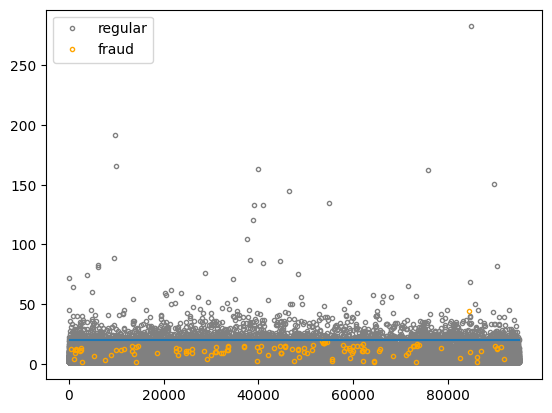

In [ ]:
# テストセットのスコア計算
score = np.round(loss_each, 5)
regular_idx = np.where(y_test==0)[0]
anomaly_idx = np.where(y_test==1)[0]
# プロット
plt.plot(regular_idx, score[regular_idx], linestyle='None', marker='.', color='gray', markerfacecolor='None', label='regular')
plt.plot(anomaly_idx, score[anomaly_idx], linestyle='None', marker='.', color='orange', markerfacecolor='None', label='fraud')
#plt.ylim(0,20)
import matplotlib.pyplot as plt
xmin, xmax = 0, 95000
plt.hlines(20, xmin, xmax)
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.where(score >= 20, 0, 1),labels=[1, 0])
print(cm)

[[  120     1]
 [93146  1574]]


In [ ]:
#不正利用検知の精度は高いとは言えないが、不正の可能性が少ない優良利用群を特定することに使えるかもしれない